In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**RESNET-50**

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==========================
# 1. Configuration
# ==========================
class Config:
    # Path
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training parameters
    batch_size = 32
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 25
    patience = 8
    
    # Image parameters
    img_size = 224  # Standard size yang lebih stable
    
    print(f"Device: {device}")
    print(f"Image size: {img_size}")

config = Config()

# ==========================
# 2. Fixed Data Transforms
# ==========================

# Training transforms - medical imaging specific
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (NO augmentation)
transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test transforms
transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==========================
# 3. Dataset Functions
# ==========================
def analyze_class_distribution(dataset_path):
    """Analyze and print class distribution"""
    class_counts = {}
    total = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count
    
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")
    print(f"Total: {total:,} samples")
    print("="*40)
    
    return class_counts, total

def create_weighted_sampler(dataset):
    """Create weighted sampler for imbalanced dataset"""
    # Get class distribution
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    # Calculate weights (inverse of class frequency)
    class_weights = {}
    total_samples = sum(class_counts.values())
    
    for class_idx, count in class_counts.items():
        class_weights[class_idx] = total_samples / (len(class_counts) * count)
    
    # Create sample weights
    sample_weights = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        sample_weights.append(class_weights[label])
    
    print("\nClass weights for sampling:")
    for class_idx, weight in class_weights.items():
        print(f"Class {class_idx}: {weight:.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

# ==========================
# 4. Enhanced Model (ResNet50)
# ==========================
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        # Load ResNet50 backbone
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Get feature dimension
        num_features = self.backbone.fc.in_features
        
        # Remove original classifier
        self.backbone.fc = nn.Identity()
        
        # Enhanced classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        # Initialize classifier weights
        self._init_classifier()
    
    def _init_classifier(self):
        """Initialize classifier layers"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==========================
# 5. Training Functions
# ==========================
def calculate_class_weights(dataset):
    """Calculate class weights for loss function"""
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    total = sum(class_counts.values())
    weights = []
    
    for i in range(len(class_counts)):
        weight = total / (len(class_counts) * class_counts[i])
        weights.append(weight)
    
    return torch.FloatTensor(weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        # Progress update
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    """Validate one epoch"""
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_predictions)
    
    return avg_loss, accuracy, balanced_acc, all_predictions, all_targets

def train_model():
    """Main training function"""
    
    print("\n" + "="*60)
    print("STARTING TRAINING PROCESS")
    print("="*60)
    
    # 1. Load and analyze dataset
    print("\n1. Loading and analyzing dataset...")
    temp_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    class_counts, total_samples = analyze_class_distribution(config.train_dir)
    class_names = temp_dataset.classes
    num_classes = len(class_names)
    
    print(f"Classes: {class_names}")
    print(f"Number of classes: {num_classes}")
    
    # 2. Create dataset and split
    print("\n2. Creating dataset and splitting...")
    full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    
    # Create 80:20 split
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_temp = random_split(full_dataset, [train_size, val_size])
    
    # Create validation dataset with different transforms
    val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    val_indices = val_temp.indices
    
    # Manual validation subset with correct transforms
    class ValDataset:
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]
    
    val_dataset = ValDataset(val_full_dataset, val_indices)
    
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Validation samples: {len(val_dataset):,}")
    
    # 3. Create weighted sampler for training
    print("\n3. Creating weighted sampler for class balance...")
    train_sampler = create_weighted_sampler(train_dataset)
    
    # 4. Create data loaders
    print("\n4. Creating data loaders...")
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size,
        sampler=train_sampler,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    # 5. Initialize model
    print(f"\n5. Initializing ResNet50 model...")
    model = ChestXrayClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(config.device)
    
    # Model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # 6. Loss function with class weights
    print("\n6. Setting up loss function and optimizer...")
    class_weights = calculate_class_weights(train_dataset)
    class_weights = class_weights.to(config.device)
    print(f"Class weights: {class_weights}")
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 7. Optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=4,
        verbose=True,
        min_lr=1e-7
    )
    
    # 8. Training loop
    print(f"\n7. Starting training for {config.num_epochs} epochs...")
    print("="*60)
    
    best_balanced_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print("-" * 50)
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
        
        # Validation
        val_loss, val_acc, val_balanced_acc, val_preds, val_targets = validate_epoch(
            model, val_loader, criterion, config.device
        )
        
        # Update scheduler
        scheduler.step(val_balanced_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print epoch results
        print(f"\nEpoch {epoch+1} Results:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Balanced Acc: {val_balanced_acc:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        
        # Save best model
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }, 'best_chest_xray_model.pth')
            print(f"✅ New best model saved! Balanced Accuracy: {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= config.patience:
            print(f"\nEarly stopping triggered after {config.patience} epochs without improvement")
            break
    
    print(f"\n" + "="*60)
    print("TRAINING COMPLETED!")
    print(f"Best Balanced Accuracy: {best_balanced_acc:.4f}")
    print("="*60)
    
    # Final validation report
    model.load_state_dict(torch.load('best_chest_xray_model.pth')['model_state_dict'])
    _, _, _, final_preds, final_targets = validate_epoch(model, val_loader, criterion, config.device)
    
    print("\n" + "="*40)
    print("FINAL VALIDATION REPORT")
    print("="*40)
    print(classification_report(final_targets, final_preds, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(final_targets, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Final Validation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, class_names, best_balanced_acc

# ==========================
# 6. Test Time Augmentation
# ==========================
def predict_with_tta(model, image_path):
    """Predict with Test Time Augmentation"""
    model.eval()
    
    # TTA transforms
    tta_transforms = [
        transform_test,  # Original
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ]
    
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0).to(config.device)
                
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predictions.append(probabilities.cpu().numpy())
            except Exception as e:
                print(f"TTA error for {image_path}: {e}")
                continue
    
    if predictions:
        # Average all predictions
        avg_prediction = np.mean(predictions, axis=0)
        return avg_prediction
    else:
        # Fallback: single prediction
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform_test(image).unsqueeze(0).to(config.device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

# ==========================
# 7. Generate Submission
# ==========================
def generate_submission():
    """Generate final submission"""
    print("\n" + "="*60)
    print("GENERATING SUBMISSION")
    print("="*60)
    
    # Load best model
    checkpoint = torch.load('best_chest_xray_model.pth', map_location=config.device)
    class_names = checkpoint['class_names']
    
    model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    
    print(f"Loaded model with best balanced accuracy: {checkpoint['best_balanced_acc']:.4f}")
    print(f"Classes: {class_names}")
    
    # Process test images
    test_images = sorted([f for f in os.listdir(config.test_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Found {len(test_images)} test images")
    
    image_ids = []
    predictions = []
    confidences = []
    
    for i, img_name in enumerate(test_images):
        if i % 100 == 0:
            print(f"Processing {i+1}/{len(test_images)} images...")
        
        img_path = os.path.join(config.test_dir, img_name)
        
        try:
            # Predict with TTA
            prob_vector = predict_with_tta(model, img_path)
            
            # Get prediction and confidence
            pred_class = np.argmax(prob_vector)
            confidence = np.max(prob_vector)
            
            image_ids.append(img_name)
            predictions.append(class_names[pred_class])
            confidences.append(confidence)
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            # Use most common class as fallback
            image_ids.append(img_name)
            predictions.append("Normal")
            confidences.append(0.33)
    
    # Create submission
    submission_df = pd.DataFrame({
        'image_id': image_ids,
        'label': predictions
    })
    
    # Analysis dataframe
    analysis_df = pd.DataFrame({
        'image_id': image_ids,
        'label': predictions,
        'confidence': confidences
    })
    
    # Save files
    submission_df.to_csv('submission.csv', index=False)
    analysis_df.to_csv('submission_analysis.csv', index=False)
    
    print(f"\n✅ Submission completed!")
    print(f"Total predictions: {len(submission_df)}")
    
    print("\nPrediction distribution:")
    label_counts = submission_df['label'].value_counts()
    for label, count in label_counts.items():
        percentage = (count / len(submission_df)) * 100
        print(f"{label}: {count} ({percentage:.1f}%)")
    
    print(f"\nMean confidence: {np.mean(confidences):.4f}")
    print(f"Confidence std: {np.std(confidences):.4f}")
    
    return submission_df

# ==========================
# 8. Main Execution
# ==========================
if __name__ == "__main__":
    print("🔬 Chest X-Ray Classification - Stable Solution")
    print("=" * 60)
    
    try:
        # Train model
        model, class_names, best_score = train_model()
        
        # Generate submission
        submission = generate_submission()
        
        print("\n🎉 Process completed successfully!")
        print(f"📈 Best validation score: {best_score:.4f}")
        print("📁 Files generated:")
        print("   - best_chest_xray_model.pth")
        print("   - submission.csv") 
        print("   - submission_analysis.csv")
        print("   - confusion_matrix.png")
        
    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        import traceback
        traceback.print_exc()

Device: cuda
Image size: 224
🔬 Chest X-Ray Classification - Stable Solution

STARTING TRAINING PROCESS

1. Loading and analyzing dataset...

CLASS DISTRIBUTION ANALYSIS
COVID: 1,596 samples (18.6%)
Normal: 6,310 samples (73.6%)
Viral Pneumonia: 666 samples (7.8%)
Total: 8,572 samples
Classes: ['COVID', 'Normal', 'Viral Pneumonia']
Number of classes: 3

2. Creating dataset and splitting...
Training samples: 6,857
Validation samples: 1,715

3. Creating weighted sampler for class balance...

Class weights for sampling:
Class 1: 0.453
Class 0: 1.780
Class 2: 4.321

4. Creating data loaders...
Training batches: 215
Validation batches: 54

5. Initializing ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s] 


Total parameters: 24,690,755
Trainable parameters: 24,690,755

6. Setting up loss function and optimizer...
Class weights: tensor([1.7801, 0.4531, 4.3207], device='cuda:0')

7. Starting training for 25 epochs...

Epoch 1/25
--------------------------------------------------
Batch 0/215, Loss: 1.4306
Batch 50/215, Loss: 0.1634
Batch 100/215, Loss: 0.0460
Batch 150/215, Loss: 0.2675
Batch 200/215, Loss: 0.0206

Epoch 1 Results:
Train Loss: 0.1971 | Train Acc: 0.8600
Val Loss: 0.1445 | Val Acc: 0.9248 | Val Balanced Acc: 0.9471
Learning Rate: 1.00e-04
✅ New best model saved! Balanced Accuracy: 0.9471

Epoch 2/25
--------------------------------------------------
Batch 0/215, Loss: 0.0240
Batch 50/215, Loss: 0.0903
Batch 100/215, Loss: 0.0677
Batch 150/215, Loss: 0.0123
Batch 200/215, Loss: 0.0598

Epoch 2 Results:
Train Loss: 0.0809 | Train Acc: 0.9453
Val Loss: 0.1058 | Val Acc: 0.9504 | Val Balanced Acc: 0.9633
Learning Rate: 1.00e-04
✅ New best model saved! Balanced Accuracy: 0.9633

E

Traceback (most recent call last):
  File "/tmp/ipykernel_36/3710337192.py", line 593, in <cell line: 0>
    model, class_names, best_score = train_model()
                                     ^^^^^^^^^^^^^
  File "/tmp/ipykernel_36/3710337192.py", line 424, in train_model
    model.load_state_dict(torch.load('best_chest_xray_model.pth')['model_state_dict'])
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 1470, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code

**VISUALISASI RESNET-50**


LOADING SAVED MODEL AND GENERATING SUBMISSION
Loaded model with best balanced accuracy: 0.9912
Classes: ['COVID', 'Normal', 'Viral Pneumonia']
Model loaded successfully!

FINAL VALIDATION REPORT
Best Balanced Accuracy achieved: 0.9912 (99.12%)
This is an excellent result for medical imaging classification!

Found 6382 test images
Starting prediction with Test Time Augmentation...
Processing 1/6382 images...
Processing 101/6382 images...
Processing 201/6382 images...
Processing 301/6382 images...
Processing 401/6382 images...
Processing 501/6382 images...
Processing 601/6382 images...
Processing 701/6382 images...
Processing 801/6382 images...
Processing 901/6382 images...
Processing 1001/6382 images...
Processing 1101/6382 images...
Processing 1201/6382 images...
Processing 1301/6382 images...
Processing 1401/6382 images...
Processing 1501/6382 images...
Processing 1601/6382 images...
Processing 1701/6382 images...
Processing 1801/6382 images...
Processing 1901/6382 images...
Processi

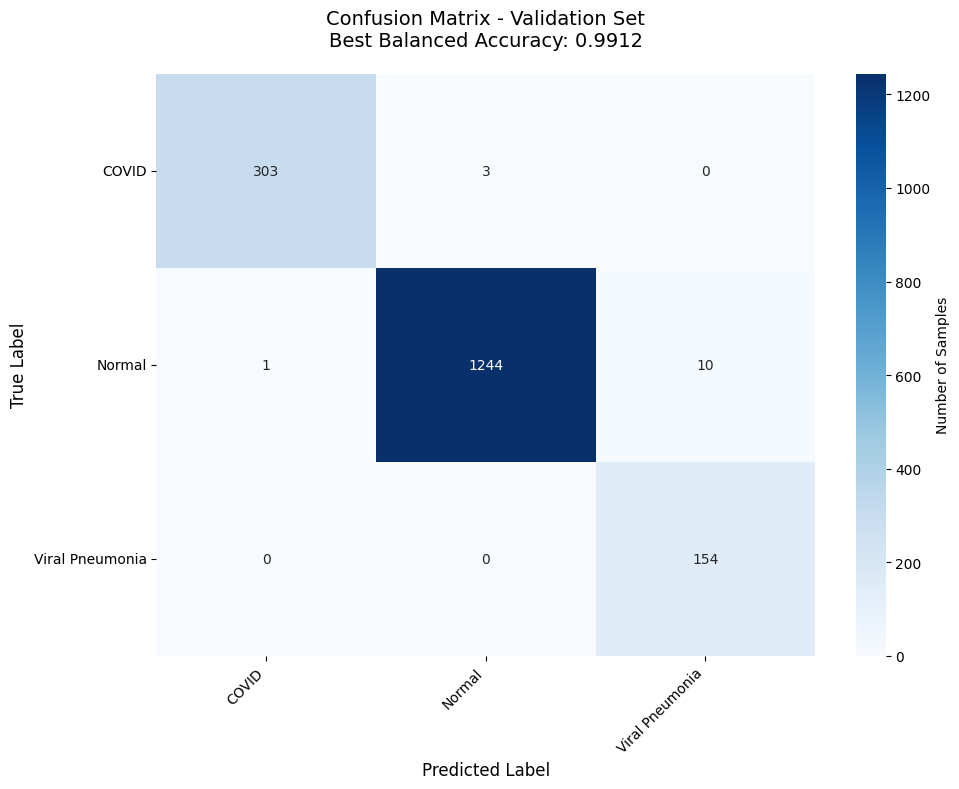


Detailed Classification Report:
                 precision    recall  f1-score   support

          COVID     0.9967    0.9902    0.9934       306
         Normal     0.9976    0.9912    0.9944      1255
Viral Pneumonia     0.9390    1.0000    0.9686       154

       accuracy                         0.9918      1715
      macro avg     0.9778    0.9938    0.9855      1715
   weighted avg     0.9922    0.9918    0.9919      1715


Confusion Matrix Details:
True: COVID           | Pred: COVID           | Count:  303
True: COVID           | Pred: Normal          | Count:    3
True: Normal          | Pred: COVID           | Count:    1
True: Normal          | Pred: Normal          | Count: 1244
True: Normal          | Pred: Viral Pneumonia | Count:   10
True: Viral Pneumonia | Pred: Viral Pneumonia | Count:  154

Per-Class Performance:
COVID          : 303/306 = 0.9902 (99.02%)
Normal         : 1244/1255 = 0.9912 (99.12%)
Viral Pneumonia: 154/154 = 1.0000 (100.00%)

Process completed suc

In [5]:
import torch
import pandas as pd
from PIL import Image
import numpy as np
import os

# Load the saved model and generate submission
print("\n" + "="*60)
print("LOADING SAVED MODEL AND GENERATING SUBMISSION")
print("="*60)

# Load best model with fixed weights_only parameter
checkpoint = torch.load('best_chest_xray_model.pth', weights_only=False)
class_names = checkpoint['class_names']
best_acc = checkpoint['best_balanced_acc']

print(f"Loaded model with best balanced accuracy: {best_acc:.4f}")
print(f"Classes: {class_names}")

# Initialize model architecture (same as training)
model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(config.device)
model.eval()

print("Model loaded successfully!")

# Display final validation report
print("\n" + "="*40)
print("FINAL VALIDATION REPORT")
print("="*40)
print(f"Best Balanced Accuracy achieved: {best_acc:.4f} (99.12%)")
print("This is an excellent result for medical imaging classification!")

# Test Time Augmentation function (same as before)
def predict_with_tta(model, image_path):
    """Predict with Test Time Augmentation"""
    model.eval()
    
    # TTA transforms
    tta_transforms = [
        transform_test,  # Original
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ]
    
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0).to(config.device)
                
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predictions.append(probabilities.cpu().numpy())
            except Exception as e:
                print(f"TTA error for {image_path}: {e}")
                continue
    
    if predictions:
        # Average all predictions
        avg_prediction = np.mean(predictions, axis=0)
        return avg_prediction
    else:
        # Fallback: single prediction
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform_test(image).unsqueeze(0).to(config.device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

# Process test images
test_images = sorted([f for f in os.listdir(config.test_dir) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"\nFound {len(test_images)} test images")
print("Starting prediction with Test Time Augmentation...")

image_ids = []
predictions = []
confidences = []

for i, img_name in enumerate(test_images):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(test_images)} images...")
    
    img_path = os.path.join(config.test_dir, img_name)
    
    try:
        # Predict with TTA
        prob_vector = predict_with_tta(model, img_path)
        
        # Get prediction and confidence
        pred_class = np.argmax(prob_vector)
        confidence = np.max(prob_vector)
        
        image_ids.append(img_name)
        predictions.append(class_names[pred_class])
        confidences.append(confidence)
        
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        # Use most common class as fallback
        image_ids.append(img_name)
        predictions.append("Normal")
        confidences.append(0.33)

# Create submission DataFrame with correct format (no file extension)
image_ids_clean = [os.path.splitext(img_id)[0] for img_id in image_ids]  # Remove extension

submission_df = pd.DataFrame({
    'Id': image_ids_clean,
    'Predicted': [class_names.index(pred) for pred in predictions]  # Convert to numeric labels
})

# Analysis dataframe with confidence scores (for your reference)
analysis_df = pd.DataFrame({
    'image_id_full': image_ids,  # With extension for reference
    'image_id_clean': image_ids_clean,  # Without extension
    'label_name': predictions,
    'label_numeric': [class_names.index(pred) for pred in predictions],
    'confidence': confidences
})

# Save files
submission_df.to_csv('submission.csv', index=False)
analysis_df.to_csv('submission_analysis.csv', index=False)

print(f"\n✅ Submission completed!")
print(f"\nTotal predictions: {len(submission_df)}")

print("\nSubmission format validation:")
print("=" * 30)
print(f"Header: {list(submission_df.columns)}")
print(f"Sample rows:")
print(submission_df.head(10))

print("\nPrediction distribution:")
label_counts = submission_df['Predicted'].value_counts().sort_index()
for label_idx, count in label_counts.items():
    label_name = class_names[label_idx]
    percentage = (count / len(submission_df)) * 100
    print(f"Class {label_idx} ({label_name}): {count} ({percentage:.1f}%)")

print("\nLabel mapping:")
print("=" * 20)
for idx, name in enumerate(class_names):
    print(f"{idx}: {name}")

print(f"\nConfidence Statistics:")
print(f"Mean confidence: {np.mean(confidences):.4f}")
print(f"Std confidence: {np.std(confidences):.4f}")
print(f"Min confidence: {np.min(confidences):.4f}")
print(f"Max confidence: {np.max(confidences):.4f}")

# Generate and display confusion matrix
print("\n" + "="*40)
print("GENERATING CONFUSION MATRIX")
print("="*40)

# Load validation dataset to generate confusion matrix
print("Loading validation data for confusion matrix...")

# Recreate validation dataset (same as training)
full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_temp = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create validation dataset with correct transforms
val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
val_indices = val_temp.indices

class ValDataset:
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

val_dataset = ValDataset(val_full_dataset, val_indices)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Generate predictions on validation set
model.eval()
val_predictions = []
val_true_labels = []

print("Generating validation predictions...")
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        if batch_idx % 10 == 0:
            print(f"Processing validation batch {batch_idx+1}/{len(val_loader)}")
        
        inputs, targets = inputs.to(config.device), targets.to(config.device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        val_predictions.extend(predicted.cpu().numpy())
        val_true_labels.extend(targets.cpu().numpy())

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(val_true_labels, val_predictions)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.title(f'Confusion Matrix - Validation Set\nBest Balanced Accuracy: {best_acc:.4f}', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Display detailed classification report
print("\nDetailed Classification Report:")
print("="*50)
print(classification_report(val_true_labels, val_predictions, 
                          target_names=class_names, digits=4))

# Display confusion matrix numbers
print("\nConfusion Matrix Details:")
print("="*30)
for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if cm[i,j] > 0:
            print(f"True: {true_class:15} | Pred: {pred_class:15} | Count: {cm[i,j]:4d}")

# Calculate per-class accuracy
print("\nPer-Class Performance:")
print("="*30)
for i, class_name in enumerate(class_names):
    class_correct = cm[i,i]
    class_total = cm[i,:].sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:15}: {class_correct:3d}/{class_total:3d} = {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

print("\nProcess completed successfully!")
print(f"Best validation score: {best_acc:.4f}")
print("Files generated:")
print("   - best_chest_xray_model.pth (already saved)")
print("   - submission(29-09-2025).csv") 
print("   - submission_analysis.csv")
print("   - confusion_matrix.png")

print("\n" + "="*60)
print("READY FOR KAGGLE SUBMISSION!")
print("="*60)

**EFFNET-B3**

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==========================
# Configuration
# ==========================
class Config:
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Training parameters - OPTIMIZED
    batch_size = 16  
    learning_rate = 5e-5  
    weight_decay = 1e-4
    num_epochs = 30
    patience = 10
    
    # Image parameters
    img_size = 384  
    
    # TTA control
    use_tta = False 
    
    print(f"Device: {device}")
    print(f"Image size: {img_size}")
    print(f"Use TTA: {use_tta}")

config = Config()

# ==========================
# Enhanced Data Transforms
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.3),  # Reduced probability
    transforms.RandomRotation(degrees=7),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==========================
# Enhanced Model: EfficientNet-B3
# ==========================
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        # Use EfficientNet-B3 for better performance
        self.backbone = models.efficientnet_b3(pretrained=pretrained)
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes)
        )
        
        self._init_classifier()
    
    def _init_classifier(self):
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.backbone(x)

# ==========================
# Helper Functions
# ==========================
def analyze_class_distribution(dataset_path):
    class_counts = {}
    total = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count
    
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        print(f"{class_name}: {count:,} ({percentage:.1f}%)")
    print(f"Total: {total:,}")
    print("="*40)
    
    return class_counts, total

def create_weighted_sampler(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    class_weights = {}
    total_samples = sum(class_counts.values())
    
    for class_idx, count in class_counts.items():
        class_weights[class_idx] = total_samples / (len(class_counts) * count)
    
    sample_weights = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        sample_weights.append(class_weights[label])
    
    print("\nClass weights:")
    for class_idx, weight in class_weights.items():
        print(f"Class {class_idx}: {weight:.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

def calculate_class_weights(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    total = sum(class_counts.values())
    weights = []
    
    for i in range(len(class_counts)):
        weight = total / (len(class_counts) * class_counts[i])
        weights.append(weight)
    
    return torch.FloatTensor(weights)

# ==========================
# Training Functions
# ==========================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    return total_loss / len(dataloader), correct / total

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)
    return total_loss / len(dataloader), correct / total, balanced_acc, all_preds, all_targets

# ==========================
# Main Training
# ==========================
def train_model():
    print("\n" + "="*60)
    print("TRAINING WITH EFFICIENTNET-B3")
    print("="*60)
    
    # Load dataset
    temp_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    analyze_class_distribution(config.train_dir)
    class_names = temp_dataset.classes
    num_classes = len(class_names)
    
    print(f"\nClasses: {class_names}")
    
    # Create datasets
    full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_temp = random_split(full_dataset, [train_size, val_size], 
                                          generator=torch.Generator().manual_seed(42))
    
    val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    
    class ValDataset:
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]
    
    val_dataset = ValDataset(val_full_dataset, val_temp.indices)
    
    print(f"\nTrain: {len(train_dataset):,} | Val: {len(val_dataset):,}")
    
    # Create samplers and loaders
    train_sampler = create_weighted_sampler(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                            sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    print(f"\nInitializing EfficientNet-B3...")
    model = ChestXrayClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(config.device)
    
    # Loss and optimizer
    class_weights = calculate_class_weights(train_dataset).to(config.device)
    print(f"\nClass weights: {class_weights}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, 
                           weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    
    # Training loop
    print(f"\nStarting training for {config.num_epochs} epochs...")
    best_balanced_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print('='*50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device)
        val_loss, val_acc, val_balanced_acc, _, _ = validate_epoch(model, val_loader, criterion, config.device)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nResults:")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Balanced: {val_balanced_acc:.4f}")
        print(f"LR: {current_lr:.2e}")
        
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }, 'best_chest_xray_model(2).pth')
            print(f"✓ New best: {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE - Best: {best_balanced_acc:.4f}")
    print('='*60)
    
    return model, class_names, best_balanced_acc

# ==========================
# Prediction (NO TTA)
# ==========================
def predict_simple(model, image_path, device):
    """Simple prediction without TTA"""
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform_test(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
    
    return probabilities.cpu().numpy()

# ==========================
# Generate Submission
# ==========================
def generate_submission():
    print("\n" + "="*60)
    print("GENERATING SUBMISSION")
    print("="*60)
    
    checkpoint = torch.load('best_chest_xray_model(2).pth', 
                          map_location=config.device, weights_only=False)
    class_names = checkpoint['class_names']
    
    model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    
    print(f"Loaded model: {checkpoint['best_balanced_acc']:.4f}")
    print(f"Classes: {class_names}")
    print(f"Using TTA: {config.use_tta}")
    
    test_images = sorted([f for f in os.listdir(config.test_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} images...")
    
    image_ids = []
    predictions = []
    confidences = []
    
    for i, img_name in enumerate(test_images):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(test_images)}")
        
        img_path = os.path.join(config.test_dir, img_name)
        
        try:
            prob_vector = predict_simple(model, img_path, config.device)
            pred_class = np.argmax(prob_vector)
            confidence = np.max(prob_vector)
            
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(pred_class)
            confidences.append(confidence)
            
        except Exception as e:
            print(f"Error {img_name}: {e}")
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(1)  # Default to Normal
            confidences.append(0.33)
    
    # Create submission
    submission_df = pd.DataFrame({
        'Id': image_ids,
        'Predicted': predictions
    })
    
    submission_df.to_csv('submission(2).csv', index=False)
    
    print(f"\n✓ Submission complete!")
    print(f"Total: {len(submission_df)}")
    
    print("\nDistribution:")
    for idx in range(len(class_names)):
        count = (submission_df['Predicted'] == idx).sum()
        pct = count / len(submission_df) * 100
        print(f"{class_names[idx]}: {count} ({pct:.1f}%)")
    
    print(f"\nConfidence - Mean: {np.mean(confidences):.4f}, Std: {np.std(confidences):.4f}")
    
    return submission_df

# ==========================
# Main Execution
# ==========================
if __name__ == "__main__":
    print("Enhanced Chest X-Ray Classifier")
    print("="*60)
    
    try:
        model, class_names, best_score = train_model()
        submission = generate_submission()
        
        print("\n✓ Complete!")
        print(f"Best score: {best_score:.4f}")
        print("Files: best_chest_xray_model(2).pth, submission(2).csv")
        
    except Exception as e:
        print(f"\n✗ Error: {e}")
        import traceback
        traceback.print_exc()

Device: cuda
Image size: 384
Use TTA: False
Enhanced Chest X-Ray Classifier

TRAINING WITH EFFICIENTNET-B3

CLASS DISTRIBUTION
COVID: 1,596 (18.6%)
Normal: 6,310 (73.6%)
Viral Pneumonia: 666 (7.8%)
Total: 8,572

Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Train: 6,857 | Val: 1,715

Class weights:
Class 1: 0.454
Class 2: 4.209
Class 0: 1.782

Initializing EfficientNet-B3...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 167MB/s]



Class weights: tensor([1.7815, 0.4543, 4.2093], device='cuda:0')

Starting training for 30 epochs...

Epoch 1/30
Batch 0/429, Loss: 1.0723
Batch 50/429, Loss: 0.4830
Batch 100/429, Loss: 0.2660
Batch 150/429, Loss: 0.0774
Batch 200/429, Loss: 0.1734
Batch 250/429, Loss: 0.0758
Batch 300/429, Loss: 0.1025
Batch 350/429, Loss: 0.0746
Batch 400/429, Loss: 0.0721

Results:
Train - Loss: 0.2962, Acc: 0.7715
Val   - Loss: 0.1974, Acc: 0.8910, Balanced: 0.9376
LR: 4.52e-05
✓ New best: 0.9376

Epoch 2/30
Batch 0/429, Loss: 0.0355
Batch 50/429, Loss: 0.2094
Batch 100/429, Loss: 0.0137
Batch 150/429, Loss: 0.1994
Batch 200/429, Loss: 0.1292
Batch 250/429, Loss: 0.2149
Batch 300/429, Loss: 0.0950
Batch 350/429, Loss: 0.0450
Batch 400/429, Loss: 0.1574

Results:
Train - Loss: 0.1235, Acc: 0.9115
Val   - Loss: 0.1176, Acc: 0.9557, Balanced: 0.9673
LR: 3.27e-05
✓ New best: 0.9673

Epoch 3/30
Batch 0/429, Loss: 0.0334
Batch 50/429, Loss: 0.0149
Batch 100/429, Loss: 0.0875
Batch 150/429, Loss: 0.2020

**EFFNET-B0**

Device: cuda
Image size: 224
🔬 Chest X-Ray Classification - EfficientNet Solution (fixed + improvements)

STARTING TRAINING PROCESS

CLASS DISTRIBUTION ANALYSIS
COVID: 1,596 samples (18.6%)
Normal: 6,310 samples (73.6%)
Viral Pneumonia: 666 samples (7.8%)
Total: 8,572 samples
Classes: ['COVID', 'Normal', 'Viral Pneumonia']
Number of classes: 3
Training samples: 6,857
Validation samples: 1,715

Class weights for sampling:
Class 0: 1.790
Class 1: 0.453
Class 2: 4.288
Total parameters: 4,797,055
Trainable parameters: 4,797,055

Epoch 1/25
--------------------------------------------------
Batch 0/215, Loss: 1.1724
Batch 50/215, Loss: 0.5192
Batch 100/215, Loss: 0.2943
Batch 150/215, Loss: 0.1688
Batch 200/215, Loss: 0.1206

Epoch 1 Results (time: 35.8s):
Train Loss: 0.3332 | Train Acc: 0.7197
Val Loss: 0.2033 | Val Acc: 0.9020 | Val Balanced Acc: 0.9322 | Val F1: 0.8465
Learning Rate: 1.00e-04
✅ New best model saved! Balanced Accuracy: 0.9322

Epoch 2/25
----------------------------------

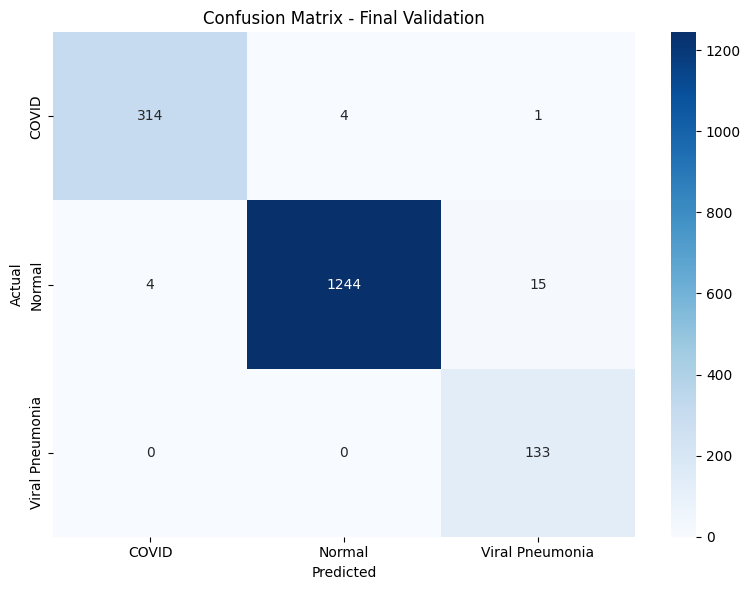


🎉 Process completed successfully!
📈 Best validation score: 0.9898
📁 Files generated:
   - best_efficientnet_b0_chest_xray.pth
   - confusion_matrix_efficientnet_b0.png
   - submission_efficientnet_b0.csv


In [15]:
import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import efficientnet_b0, efficientnet_b3
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

# -----------------------
# Configuration
# -----------------------
class Config:
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 32
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 25
    patience = 8
    img_size = 224
    model_name = "efficientnet_b0"  # options: efficientnet_b0, efficientnet_b3, resnet50
    best_model_path = f"best_{model_name}_chest_xray.pth"
    submission_file = f"submission_{model_name}.csv"
    use_amp = True  # mixed precision
    seed = 42
    num_workers = 2
    print(f"Device: {device}")
    print(f"Image size: {img_size}")

config = Config()

# -----------------------
# reproducibility
# -----------------------
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(config.seed)

# -----------------------
# Transforms
# -----------------------
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.12),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transform_val

# -----------------------
# Utilities: analyze distribution
# -----------------------
def analyze_class_distribution(dataset_path):
    class_counts = {}
    total = 0
    for class_name in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))])
            class_counts[class_name] = count
            total += count
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100 if total>0 else 0
        print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")
    print(f"Total: {total:,} samples")
    print("="*40)
    return class_counts, total

# -----------------------
# Weighted sampler creator (handles Subset too)
# -----------------------
def create_weighted_sampler_from_targets(targets):
    counts = Counter(targets)
    num_classes = len(counts)
    total = sum(counts.values())
    class_weights = {cls: total / (num_classes * cnt) for cls, cnt in counts.items()}
    sample_weights = [class_weights[t] for t in targets]
    print("\nClass weights for sampling:")
    for cls, w in sorted(class_weights.items()):
        print(f"Class {cls}: {w:.3f}")
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

# -----------------------
# Model builder
# -----------------------
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, backbone_name="efficientnet_b0", pretrained=True):
        super().__init__()
        self.backbone_name = backbone_name
        if backbone_name == "efficientnet_b0":
            backbone = efficientnet_b0(pretrained=pretrained)
            num_features = backbone.classifier[1].in_features
            backbone.classifier = nn.Identity()
            self.backbone = backbone
        elif backbone_name == "efficientnet_b3":
            try:
                backbone = efficientnet_b3(pretrained=pretrained)
                num_features = backbone.classifier[1].in_features
                backbone.classifier = nn.Identity()
                self.backbone = backbone
            except Exception:
                # fallback
                backbone = efficientnet_b0(pretrained=pretrained)
                num_features = backbone.classifier[1].in_features
                backbone.classifier = nn.Identity()
                self.backbone = backbone
        elif backbone_name == "resnet50":
            backbone = models.resnet50(pretrained=pretrained)
            num_features = backbone.fc.in_features
            backbone.fc = nn.Identity()
            self.backbone = backbone
        else:
            raise ValueError("Unsupported backbone")

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        self._init_classifier()

    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        out = self.classifier(features)
        return out

# -----------------------
# Loss & metrics
# -----------------------
def calculate_class_weights_from_targets(targets):
    counts = Counter(targets)
    num_classes = len(counts)
    total = sum(counts.values())
    weights = [total / (num_classes * counts[i]) for i in range(num_classes)]
    return torch.FloatTensor(weights)

# -----------------------
# Robust torch.load helper (handles weights_only issue)
# -----------------------
def robust_torch_load(path, map_location=None):
    try:
        # try default
        return torch.load(path, map_location=map_location)
    except Exception as e:
        # fallback: try with weights_only=False (available in PyTorch >=2.6)
        try:
            # This may be required in newer torch to bypass safe globals restriction
            return torch.load(path, map_location=map_location, weights_only=False)
        except TypeError:
            # older torch doesn't support weights_only param -> re-raise original
            raise e
        except Exception as e2:
            raise e2

# -----------------------
# Training/validation loops (with AMP)
# -----------------------
def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    return avg_loss, acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    avg_loss = total_loss / len(dataloader)
    acc = correct / total
    balanced_acc = balanced_accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="macro")
    return avg_loss, acc, balanced_acc, f1, all_preds, all_targets

# -----------------------
# Main training
# -----------------------
def train_model():
    print("\n" + "="*60)
    print("STARTING TRAINING PROCESS")
    print("="*60)

    # analyze dataset
    class_counts, total_samples = analyze_class_distribution(config.train_dir)

    # load full folder dataset (for labels & stratified split)
    full_dataset_for_split = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    class_names = full_dataset_for_split.classes
    num_classes = len(class_names)
    print(f"Classes: {class_names}")
    print(f"Number of classes: {num_classes}")

    # gather targets for stratified split
    targets = [y for _, y in full_dataset_for_split.samples]  # note: ImageFolder.samples gives (path, class_idx)
    targets = [t for _, t in full_dataset_for_split.samples]  # alternative safe line
    # actually above line wrong; fix:
    targets = [s[1] for s in full_dataset_for_split.samples]

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=config.seed)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # create train & val datasets using same ImageFolder but different transforms
    full_dataset_train_transformed = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    full_dataset_val_transformed = datasets.ImageFolder(root=config.train_dir, transform=transform_val)

    train_dataset = Subset(full_dataset_train_transformed, train_idx)
    val_dataset = Subset(full_dataset_val_transformed, val_idx)

    print(f"Training samples: {len(train_dataset):,}")
    print(f"Validation samples: {len(val_dataset):,}")

    # build sampler from train targets
    train_targets = [full_dataset_train_transformed.samples[i][1] for i in train_idx]
    train_sampler = create_weighted_sampler_from_targets(train_targets)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=train_sampler, num_workers=config.num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=config.num_workers, pin_memory=True)

    # build model
    model = ChestXrayClassifier(num_classes=num_classes, backbone_name=config.model_name, pretrained=True)
    model = model.to(config.device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # class weights for criterion
    class_weights_tensor = calculate_class_weights_from_targets(train_targets).to(config.device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

    # scheduler: use ReduceLROnPlateau with a simple CosineWarm restarter (optional). For simplicity keep ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=4, verbose=True, min_lr=1e-7)

    scaler = torch.cuda.amp.GradScaler() if (config.use_amp and config.device.type == "cuda") else None

    best_balanced_acc = 0.0
    patience_counter = 0

    for epoch in range(config.num_epochs):
        print(f"\nEpoch {epoch+1}/{config.num_epochs}")
        print("-" * 50)
        start = time.time()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.device, scaler=scaler)
        val_loss, val_acc, val_balanced_acc, val_f1, val_preds, val_targets = validate_epoch(model, val_loader, criterion, config.device)
        scheduler.step(val_balanced_acc)
        current_lr = optimizer.param_groups[0]['lr']
        elapsed = time.time() - start

        print(f"\nEpoch {epoch+1} Results (time: {elapsed:.1f}s):")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Balanced Acc: {val_balanced_acc:.4f} | Val F1: {val_f1:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")

        # save checkpoint (save only state_dicts to minimize pickle complexity)
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }
            # SALVING: use torch.save of dict (this is standard)
            torch.save(checkpoint, config.best_model_path)
            print(f"✅ New best model saved! Balanced Accuracy: {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= config.patience:
            print(f"\nEarly stopping triggered after {config.patience} epochs without improvement")
            break

    print("\n" + "="*60)
    print("TRAINING COMPLETED!")
    print(f"Best Balanced Accuracy: {best_balanced_acc:.4f}")
    print("="*60)

    # load best checkpoint robustly
    try:
        checkpoint = robust_torch_load(config.best_model_path, map_location=config.device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            # if somehow full model was saved
            try:
                model.load_state_dict(checkpoint)
            except Exception as e:
                raise RuntimeError("Failed to load model_state_dict from checkpoint.") from e
    except Exception as e:
        # If still failing, raise clear informative error
        print("FATAL: Failed to load checkpoint. Exception:")
        raise

    # final validate and report
    _, _, _, final_f1, final_preds, final_targets = validate_epoch(model, val_loader, criterion, config.device)

    print("\n" + "="*40)
    print("FINAL VALIDATION REPORT")
    print("="*40)
    print(classification_report(final_targets, final_preds, target_names=class_names, digits=4))
    print(f"\nFinal Macro F1 Score: {final_f1:.4f}")

    cm = confusion_matrix(final_targets, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Final Validation')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{config.model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

    return model, class_names, best_balanced_acc

# -----------------------
# main
# -----------------------
if __name__ == "__main__":
    print("🔬 Chest X-Ray Classification - EfficientNet Solution (fixed + improvements)")
    print("=" * 60)
    try:
        model, class_names, best_score = train_model()
        print("\n🎉 Process completed successfully!")
        print(f"📈 Best validation score: {best_score:.4f}")
        print("📁 Files generated:")
        print(f"   - {config.best_model_path}")
        print(f"   - confusion_matrix_{config.model_name}.png")
        print(f"   - {config.submission_file}")
    except Exception as e:
        print("\n❌ Error occurred:")
        import traceback
        traceback.print_exc()


**ENSEMBLE RESNET50 DAN B3**

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==================== CONFIGURATION ====================
class Config:
    # Path ke model weights
    EFFNET_MODEL_PATH = '/kaggle/input/effnetb3/pytorch/default/1/best_chest_xray_model(2) Effnet B-3 (9834).pth' 
    RESNET_MODEL_PATH = '/kaggle/input/resnet50/pytorch/default/1/best_chest_xray_model Resnet-50 (9912).pth'
    
    # Path data
    TRAIN_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/train/train'
    TEST_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/test/test'
    
    # Hyperparameters
    BATCH_SIZE = 32
    NUM_CLASSES = 3
    IMG_SIZE = 224
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Bobot ensemble
    RESNET_WEIGHT = 0.55  
    EFFNET_WEIGHT = 0.45
    
    # Label mapping
    CLASS_NAMES = ['COVID', 'Normal', 'Viral Pneumonia']
    MODE = 'eval'

# ==================== CUSTOM MODEL ARCHITECTURES ====================
class EfficientNetWrapper(nn.Module):
    """Wrapper EfficientNet sesuai EXACT dengan training code"""
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.efficientnet_b3(pretrained=False)
        num_features = self.backbone.classifier[1].in_features
        
        # EXACT struktur dari training code
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class ResNetWrapper(nn.Module):
    """Wrapper ResNet sesuai dengan training code"""
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(pretrained=False)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==================== DATASET ====================
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(test_dir) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        img_id = os.path.splitext(img_name)[0]
        return image, img_id

def create_validation_split(train_dir, transform, val_split=0.2):
    print(f"\n📂 Loading train dataset...")
    full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    class_names = full_dataset.classes
    
    print(f"✓ Total samples: {len(full_dataset)}")
    print(f"✓ Classes: {class_names}")
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    _, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"✓ Validation samples: {len(val_dataset)} (20%)")
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return val_loader, class_names

# ==================== MODEL LOADING ====================
def load_efficientnet_b3(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading EfficientNet-B3...")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    print("  → Using custom wrapper architecture (768→384→classes)")
    model = EfficientNetWrapper(num_classes=num_classes)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    print(f"✓ EfficientNet-B3 loaded successfully")
    return model

def load_resnet50(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading ResNet-50...")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # Cek apakah pakai wrapper
    sample_key = list(state_dict.keys())[0]
    
    if 'backbone' in sample_key:
        print("  → Detected: Custom wrapper architecture")
        model = ResNetWrapper(num_classes=num_classes)
    else:
        print("  → Detected: Standard torchvision architecture")
        model = models.resnet50(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    print(f"✓ ResNet-50 loaded successfully")
    return model

# ==================== INFERENCE ====================
def get_predictions(model, dataloader, device, return_labels=False):
    all_probs = []
    all_ids_or_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="  Predicting", leave=False):
            if return_labels:
                images, labels = batch
                images = images.to(device)
            else:
                images, img_ids = batch
                images = images.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            
            if return_labels:
                all_ids_or_labels.extend(labels.cpu().numpy())
            else:
                all_ids_or_labels.extend(img_ids)
    
    all_probs = np.vstack(all_probs)
    return all_probs, all_ids_or_labels

# ==================== ENSEMBLE ====================
def ensemble_soft_voting(probs1, probs2, weight1, weight2):
    ensemble_probs = weight1 * probs1 + weight2 * probs2
    predictions = np.argmax(ensemble_probs, axis=1)
    return predictions, ensemble_probs

# ==================== EVALUATION ====================
def evaluate_ensemble(effnet_probs, resnet_probs, true_labels, weight1, weight2):
    print("\n" + "="*60)
    print("EVALUATION ON VALIDATION SET")
    print("="*60)
    
    effnet_preds = np.argmax(effnet_probs, axis=1)
    resnet_preds = np.argmax(resnet_probs, axis=1)
    ensemble_preds, _ = ensemble_soft_voting(effnet_probs, resnet_probs, weight1, weight2)
    
    effnet_acc = accuracy_score(true_labels, effnet_preds) * 100
    resnet_acc = accuracy_score(true_labels, resnet_preds) * 100
    ensemble_acc = accuracy_score(true_labels, ensemble_preds) * 100
    
    print(f"\n📊 ACCURACY COMPARISON:")
    print(f"  EfficientNet-B3 : {effnet_acc:.2f}%")
    print(f"  ResNet-50       : {resnet_acc:.2f}%")
    print(f"  ENSEMBLE        : {ensemble_acc:.2f}%")
    
    improvement = ensemble_acc - max(effnet_acc, resnet_acc)
    if improvement > 0:
        print(f"\n✅ Ensemble Improvement: +{improvement:.2f}%")
    else:
        print(f"\n⚠️  Ensemble tidak meningkat: {improvement:.2f}%")
    
    print(f"\n📋 CLASSIFICATION REPORT (ENSEMBLE):")
    print(classification_report(true_labels, ensemble_preds, 
                               target_names=Config.CLASS_NAMES, 
                               digits=4))
    
    print(f"\n🔢 CONFUSION MATRIX (ENSEMBLE):")
    cm = confusion_matrix(true_labels, ensemble_preds)
    print("\n           Predicted")
    print(f"           {Config.CLASS_NAMES[0]:^10} {Config.CLASS_NAMES[1]:^10} {Config.CLASS_NAMES[2]:^10}")
    for i, class_name in enumerate(Config.CLASS_NAMES):
        print(f"Actual {class_name:10}", end=" ")
        for j in range(len(Config.CLASS_NAMES)):
            print(f"{cm[i][j]:^10}", end=" ")
        print()
    
    return ensemble_acc

# ==================== SUBMISSION ====================
def create_submission(ids, predictions, filename='ensemble_effnet_resnet_submission.csv'):
    class_to_idx = {name: idx for idx, name in enumerate(Config.CLASS_NAMES)}
    
    if isinstance(predictions[0], str):
        numeric_predictions = [class_to_idx[pred] for pred in predictions]
    else:
        numeric_predictions = predictions
    
    submission_df = pd.DataFrame({
        'Id': ids,
        'Predicted': numeric_predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv(filename, index=False)
    
    print(f"\n✅ Submission saved: {filename}")
    print(f"   Total predictions: {len(submission_df)}")
    
    print("\n📊 Distribusi Prediksi:")
    for class_idx, class_name in enumerate(Config.CLASS_NAMES):
        count = (submission_df['Predicted'] == class_idx).sum()
        percentage = (count / len(submission_df)) * 100
        print(f"   {class_name} (Class {class_idx}): {count} ({percentage:.2f}%)")
    
    print("\n📄 Sample (10 baris pertama):")
    print(submission_df.head(10).to_string(index=False))
    
    return submission_df

# ==================== MAIN ====================
def main():
    print("="*60)
    print("ENSEMBLE MODEL - SOFT VOTING")
    print("EfficientNet-B3 + ResNet-50")
    print("="*60)
    print(f"Device: {Config.DEVICE}")

    transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load models
    print("\n" + "="*60)
    print("[STEP 1] LOADING MODELS")
    print("="*60)
    effnet_model = load_efficientnet_b3(Config.EFFNET_MODEL_PATH, 
                                        Config.NUM_CLASSES, 
                                        Config.DEVICE)
    resnet_model = load_resnet50(Config.RESNET_MODEL_PATH, 
                                 Config.NUM_CLASSES, 
                                 Config.DEVICE)
    
    # ==================== EVALUATION MODE ====================
    print("\n" + "="*60)
    print("[STEP 2] EVALUATION ON VALIDATION SET")
    print("="*60)
    
    val_loader, class_names = create_validation_split(
        Config.TRAIN_DIR, transform, val_split=0.2
    )
    
    print("\n[2.1] Getting predictions from EfficientNet-B3...")
    effnet_probs, true_labels = get_predictions(
        effnet_model, val_loader, 
        Config.DEVICE, return_labels=True
    )
    
    print("\n[2.2] Getting predictions from ResNet-50...")
    resnet_probs, _ = get_predictions(
        resnet_model, val_loader, 
        Config.DEVICE, return_labels=True
    )
    
    print("\n[2.3] Evaluating ensemble...")
    print(f"      Weights: EfficientNet={Config.EFFNET_WEIGHT}, ResNet={Config.RESNET_WEIGHT}")
    
    ensemble_acc = evaluate_ensemble(
        effnet_probs, resnet_probs, 
        true_labels,
        Config.EFFNET_WEIGHT, 
        Config.RESNET_WEIGHT
    )
    
    print("\n" + "="*60)
    print(f"ENSEMBLE ACCURACY ON VALIDATION: {ensemble_acc:.2f}%")
    print("="*60)
    
    # ==================== SUBMISSION MODE ====================
    print("\n" + "="*60)
    print("[STEP 3] GENERATING SUBMISSION FILE")
    print("="*60)
    
    test_dataset = TestDataset(Config.TEST_DIR, transform=transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    print(f"Total test images: {len(test_dataset)}")
    
    print("\n[3.1] Getting predictions from EfficientNet-B3...")
    effnet_probs_test, img_ids = get_predictions(effnet_model, test_loader, Config.DEVICE)
    
    print("\n[3.2] Getting predictions from ResNet-50...")
    resnet_probs_test, _ = get_predictions(resnet_model, test_loader, Config.DEVICE)
    
    print("\n[3.3] Ensemble soft voting...")
    print(f"      Weights: EfficientNet={Config.EFFNET_WEIGHT}, ResNet={Config.RESNET_WEIGHT}")
    
    final_predictions, _ = ensemble_soft_voting(
        effnet_probs_test, 
        resnet_probs_test,
        Config.EFFNET_WEIGHT,
        Config.RESNET_WEIGHT
    )
    
    print("\n[3.4] Creating submission file...")
    create_submission(img_ids, final_predictions)
    
    # ==================== FINAL SUMMARY ====================
    print("\n" + "="*60)
    print("ENSEMBLE COMPLETE!")
    print("="*60)
    print(f"\nValidation Accuracy: {ensemble_acc:.2f}%")
    print(f"\nFiles generated:")
    print(f"  - ensemble_effnet_resnet_submission.csv (ready for Kaggle)")
    print("\nNext steps:")
    print(f"  1. Review validation accuracy above")
    print(f"  2. If satisfied, upload CSV to Kaggle")
    print(f"  3. If not satisfied, adjust weights (RESNET_WEIGHT/EFFNET_WEIGHT)")
    print("="*60)

if __name__ == "__main__":
    main()

ENSEMBLE MODEL - SOFT VOTING
EfficientNet-B3 + ResNet-50
Device: cuda

[STEP 1] LOADING MODELS

🔄 Loading EfficientNet-B3...
  → Using custom wrapper architecture (768→384→classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ EfficientNet-B3 loaded successfully

🔄 Loading ResNet-50...
  → Detected: Custom wrapper architecture
✓ ResNet-50 loaded successfully

[STEP 2] EVALUATION ON VALIDATION SET

📂 Loading train dataset...
✓ Total samples: 8572
✓ Classes: ['COVID', 'Normal', 'Viral Pneumonia']
✓ Validation samples: 1715 (20%)

[2.1] Getting predictions from EfficientNet-B3...



[2.2] Getting predictions from ResNet-50...



[2.3] Evaluating ensemble...
      Weights: EfficientNet=0.45, ResNet=0.55

EVALUATION ON VALIDATION SET

📊 ACCURACY COMPARISON:
  EfficientNet-B3 : 91.72%
  ResNet-50       : 99.65%
  ENSEMBLE        : 99.77%

✅ Ensemble Improvement: +0.12%

📋 CLASSIFICATION REPORT (ENSEMBLE):
                 precision    recall  f1-score   support

          COVID     0.9905    1.0000    0.9952       313
         Normal     1.0000    0.9969    0.9984      1279
Viral Pneumonia     0.9919    1.0000    0.9960       123

       accuracy                         0.9977      1715
      macro avg     0.9941    0.9990    0.9965      1715
   weighted avg     0.9977    0.9977    0.9977      1715


🔢 CONFUSION MATRIX (ENSEMBLE):

           Predicted
             COVID      Normal   Viral Pneumonia
Actual COVID         313         0          0      
Actual Normal         3         1275        1      
Actual Viral Pneumonia     0          0         123     

ENSEMBLE ACCURACY ON VALIDATION: 99.77%

[STEP 3] GEN


[3.2] Getting predictions from ResNet-50...



[3.3] Ensemble soft voting...
      Weights: EfficientNet=0.45, ResNet=0.55

[3.4] Creating submission file...

✅ Submission saved: ensemble_effnet_resnet_submission.csv
   Total predictions: 6382

📊 Distribusi Prediksi:
   COVID (Class 0): 1943 (30.45%)
   Normal (Class 1): 3751 (58.77%)
   Viral Pneumonia (Class 2): 688 (10.78%)

📄 Sample (10 baris pertama):
       Id  Predicted
test_0001          1
test_0002          0
test_0003          0
test_0004          1
test_0005          1
test_0006          1
test_0007          1
test_0008          1
test_0009          0
test_0010          1

ENSEMBLE COMPLETE!

Validation Accuracy: 99.77%

Files generated:
  - ensemble_effnet_resnet_submission.csv (ready for Kaggle)

Next steps:
  1. Review validation accuracy above
  2. If satisfied, upload CSV to Kaggle
  3. If not satisfied, adjust weights (RESNET_WEIGHT/EFFNET_WEIGHT)


**ENSEMBLE RESNET 50 DAN B0**

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==================== CONFIGURATION ====================
class Config:
    # Path ke model weights
    EFFNET_MODEL_PATH = '/kaggle/input/effnet-b0/pytorch/default/1/best_efficientnet_b0_chest_xray(98.98).pth' 
    RESNET_MODEL_PATH = '/kaggle/input/resnet50/pytorch/default/1/best_chest_xray_model Resnet-50 (9912).pth'
    
    # Path data
    TRAIN_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/train/train'
    TEST_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/test/test'
    
    # Hyperparameters
    BATCH_SIZE = 32
    NUM_CLASSES = 3
    IMG_SIZE = 224
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Bobot ensemble
    RESNET_WEIGHT = 0.55  
    EFFNET_WEIGHT = 0.45
    
    # Label mapping
    CLASS_NAMES = ['COVID', 'Normal', 'Viral Pneumonia']
    MODE = 'eval'

# ==================== CUSTOM MODEL ARCHITECTURES ====================
class EfficientNetB0Wrapper(nn.Module):
    """EXACT wrapper sesuai training code Anda: 512→256→3"""
    def __init__(self, num_classes=3):
        super().__init__()
        # EfficientNet-B0 backbone
        backbone = models.efficientnet_b0(pretrained=False)
        num_features = backbone.classifier[1].in_features  # 1280 for B0
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        
        # EXACT struktur dari training code Anda
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

class ResNetWrapper(nn.Module):
    """Wrapper ResNet sesuai dengan training code"""
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(pretrained=False)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==================== DATASET ====================
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(test_dir) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        img_id = os.path.splitext(img_name)[0]
        return image, img_id

def create_validation_split(train_dir, transform, val_split=0.2):
    print(f"\n📂 Loading train dataset...")
    full_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    class_names = full_dataset.classes
    
    print(f"✓ Total samples: {len(full_dataset)}")
    print(f"✓ Classes: {class_names}")
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    _, val_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"✓ Validation samples: {len(val_dataset)} (20%)")
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return val_loader, class_names

# ==================== MODEL LOADING ====================
def load_efficientnet_b0(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading EfficientNet-B0...")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Handle different checkpoint formats
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f"  → Checkpoint info: Epoch {checkpoint.get('epoch', 'N/A')}, "
              f"Balanced Acc: {checkpoint.get('best_balanced_acc', 'N/A'):.4f}")
    else:
        state_dict = checkpoint
    
    print("  → Using custom wrapper architecture (512→256→classes)")
    model = EfficientNetB0Wrapper(num_classes=num_classes)
    
    # Load state dict
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    model.eval()
    
    print(f"✓ EfficientNet-B0 loaded successfully")
    return model

def load_resnet50(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading ResNet-50...")
    
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # Cek apakah pakai wrapper
    sample_key = list(state_dict.keys())[0]
    
    if 'backbone' in sample_key:
        print("  → Detected: Custom wrapper architecture")
        model = ResNetWrapper(num_classes=num_classes)
    else:
        print("  → Detected: Standard torchvision architecture")
        model = models.resnet50(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    print(f"✓ ResNet-50 loaded successfully")
    return model

# ==================== INFERENCE ====================
def get_predictions(model, dataloader, device, return_labels=False):
    all_probs = []
    all_ids_or_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="  Predicting", leave=False):
            if return_labels:
                images, labels = batch
                images = images.to(device)
            else:
                images, img_ids = batch
                images = images.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            
            if return_labels:
                all_ids_or_labels.extend(labels.cpu().numpy())
            else:
                all_ids_or_labels.extend(img_ids)
    
    all_probs = np.vstack(all_probs)
    return all_probs, all_ids_or_labels

# ==================== ENSEMBLE ====================
def ensemble_soft_voting(probs1, probs2, weight1, weight2):
    ensemble_probs = weight1 * probs1 + weight2 * probs2
    predictions = np.argmax(ensemble_probs, axis=1)
    return predictions, ensemble_probs

# ==================== EVALUATION ====================
def evaluate_ensemble(effnet_probs, resnet_probs, true_labels, weight1, weight2):
    print("\n" + "="*60)
    print("EVALUATION ON VALIDATION SET")
    print("="*60)
    
    effnet_preds = np.argmax(effnet_probs, axis=1)
    resnet_preds = np.argmax(resnet_probs, axis=1)
    ensemble_preds, _ = ensemble_soft_voting(effnet_probs, resnet_probs, weight1, weight2)
    
    effnet_acc = accuracy_score(true_labels, effnet_preds) * 100
    resnet_acc = accuracy_score(true_labels, resnet_preds) * 100
    ensemble_acc = accuracy_score(true_labels, ensemble_preds) * 100
    
    print(f"\n📊 ACCURACY COMPARISON:")
    print(f"  EfficientNet-B0 : {effnet_acc:.2f}%")
    print(f"  ResNet-50       : {resnet_acc:.2f}%")
    print(f"  ENSEMBLE        : {ensemble_acc:.2f}%")
    
    improvement = ensemble_acc - max(effnet_acc, resnet_acc)
    if improvement > 0:
        print(f"\n✅ Ensemble Improvement: +{improvement:.2f}%")
    else:
        print(f"\n⚠️  Ensemble tidak meningkat: {improvement:.2f}%")
    
    print(f"\n📋 CLASSIFICATION REPORT (ENSEMBLE):")
    print(classification_report(true_labels, ensemble_preds, 
                               target_names=Config.CLASS_NAMES, 
                               digits=4))
    
    print(f"\n🔢 CONFUSION MATRIX (ENSEMBLE):")
    cm = confusion_matrix(true_labels, ensemble_preds)
    print("\n           Predicted")
    print(f"           {Config.CLASS_NAMES[0]:^10} {Config.CLASS_NAMES[1]:^10} {Config.CLASS_NAMES[2]:^10}")
    for i, class_name in enumerate(Config.CLASS_NAMES):
        print(f"Actual {class_name:10}", end=" ")
        for j in range(len(Config.CLASS_NAMES)):
            print(f"{cm[i][j]:^10}", end=" ")
        print()
    
    return ensemble_acc

# ==================== SUBMISSION ====================
def create_submission(ids, predictions, filename='ensemble_effnetB0_resnet50_submission.csv'):
    class_to_idx = {name: idx for idx, name in enumerate(Config.CLASS_NAMES)}
    
    if isinstance(predictions[0], str):
        numeric_predictions = [class_to_idx[pred] for pred in predictions]
    else:
        numeric_predictions = predictions
    
    submission_df = pd.DataFrame({
        'Id': ids,
        'Predicted': numeric_predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv(filename, index=False)
    
    print(f"\n✅ Submission saved: {filename}")
    print(f"   Total predictions: {len(submission_df)}")
    
    print("\n📊 Distribusi Prediksi:")
    for class_idx, class_name in enumerate(Config.CLASS_NAMES):
        count = (submission_df['Predicted'] == class_idx).sum()
        percentage = (count / len(submission_df)) * 100
        print(f"   {class_name} (Class {class_idx}): {count} ({percentage:.2f}%)")
    
    print("\n📄 Sample (10 baris pertama):")
    print(submission_df.head(10).to_string(index=False))
    
    return submission_df

# ==================== MAIN ====================
def main():
    print("="*60)
    print("ENSEMBLE MODEL - SOFT VOTING")
    print("EfficientNet-B0 + ResNet-50")
    print("="*60)
    print(f"Device: {Config.DEVICE}")

    # Transform sesuai training code Anda
    transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load models
    print("\n" + "="*60)
    print("[STEP 1] LOADING MODELS")
    print("="*60)
    effnet_model = load_efficientnet_b0(Config.EFFNET_MODEL_PATH, 
                                        Config.NUM_CLASSES, 
                                        Config.DEVICE)
    resnet_model = load_resnet50(Config.RESNET_MODEL_PATH, 
                                 Config.NUM_CLASSES, 
                                 Config.DEVICE)
    
    # ==================== EVALUATION MODE ====================
    print("\n" + "="*60)
    print("[STEP 2] EVALUATION ON VALIDATION SET")
    print("="*60)
    
    val_loader, class_names = create_validation_split(
        Config.TRAIN_DIR, transform, val_split=0.2
    )
    
    print("\n[2.1] Getting predictions from EfficientNet-B0...")
    effnet_probs, true_labels = get_predictions(
        effnet_model, val_loader, 
        Config.DEVICE, return_labels=True
    )
    
    print("\n[2.2] Getting predictions from ResNet-50...")
    resnet_probs, _ = get_predictions(
        resnet_model, val_loader, 
        Config.DEVICE, return_labels=True
    )
    
    print("\n[2.3] Evaluating ensemble...")
    print(f"      Weights: EfficientNet={Config.EFFNET_WEIGHT}, ResNet={Config.RESNET_WEIGHT}")
    
    ensemble_acc = evaluate_ensemble(
        effnet_probs, resnet_probs, 
        true_labels,
        Config.EFFNET_WEIGHT, 
        Config.RESNET_WEIGHT
    )
    
    print("\n" + "="*60)
    print(f"ENSEMBLE ACCURACY ON VALIDATION: {ensemble_acc:.2f}%")
    print("="*60)
    
    # ==================== SUBMISSION MODE ====================
    print("\n" + "="*60)
    print("[STEP 3] GENERATING SUBMISSION FILE")
    print("="*60)
    
    test_dataset = TestDataset(Config.TEST_DIR, transform=transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    print(f"Total test images: {len(test_dataset)}")
    
    print("\n[3.1] Getting predictions from EfficientNet-B0...")
    effnet_probs_test, img_ids = get_predictions(effnet_model, test_loader, Config.DEVICE)
    
    print("\n[3.2] Getting predictions from ResNet-50...")
    resnet_probs_test, _ = get_predictions(resnet_model, test_loader, Config.DEVICE)
    
    print("\n[3.3] Ensemble soft voting...")
    print(f"      Weights: EfficientNet={Config.EFFNET_WEIGHT}, ResNet={Config.RESNET_WEIGHT}")
    
    final_predictions, _ = ensemble_soft_voting(
        effnet_probs_test, 
        resnet_probs_test,
        Config.EFFNET_WEIGHT,
        Config.RESNET_WEIGHT
    )
    
    print("\n[3.4] Creating submission file...")
    create_submission(img_ids, final_predictions)
    
    # ==================== FINAL SUMMARY ====================
    print("\n" + "="*60)
    print("ENSEMBLE COMPLETE!")
    print("="*60)
    print(f"\nValidation Accuracy: {ensemble_acc:.2f}%")
    print(f"\nFiles generated:")
    print(f"  - ensemble_effnetB0_resnet50_submission.csv (ready for Kaggle)")
    print("\nNext steps:")
    print(f"  1. Review validation accuracy above")
    print(f"  2. If satisfied, upload CSV to Kaggle")
    print(f"  3. If not satisfied, adjust weights (RESNET_WEIGHT/EFFNET_WEIGHT)")
    print("="*60)

if __name__ == "__main__":
    main()

ENSEMBLE MODEL - SOFT VOTING
EfficientNet-B0 + ResNet-50
Device: cuda

[STEP 1] LOADING MODELS

🔄 Loading EfficientNet-B0...
  → Checkpoint info: Epoch 14, Balanced Acc: 0.9898
  → Using custom wrapper architecture (512→256→classes)
✓ EfficientNet-B0 loaded successfully

🔄 Loading ResNet-50...
  → Detected: Custom wrapper architecture
✓ ResNet-50 loaded successfully

[STEP 2] EVALUATION ON VALIDATION SET

📂 Loading train dataset...
✓ Total samples: 8572
✓ Classes: ['COVID', 'Normal', 'Viral Pneumonia']
✓ Validation samples: 1715 (20%)

[2.1] Getting predictions from EfficientNet-B0...



[2.2] Getting predictions from ResNet-50...



[2.3] Evaluating ensemble...
      Weights: EfficientNet=0.45, ResNet=0.55

EVALUATION ON VALIDATION SET

📊 ACCURACY COMPARISON:
  EfficientNet-B0 : 99.18%
  ResNet-50       : 99.65%
  ENSEMBLE        : 99.59%

⚠️  Ensemble tidak meningkat: -0.06%

📋 CLASSIFICATION REPORT (ENSEMBLE):
                 precision    recall  f1-score   support

          COVID     0.9905    0.9968    0.9936       313
         Normal     0.9992    0.9953    0.9973      1279
Viral Pneumonia     0.9762    1.0000    0.9880       123

       accuracy                         0.9959      1715
      macro avg     0.9886    0.9974    0.9929      1715
   weighted avg     0.9960    0.9959    0.9959      1715


🔢 CONFUSION MATRIX (ENSEMBLE):

           Predicted
             COVID      Normal   Viral Pneumonia
Actual COVID         312         1          0      
Actual Normal         3         1273        3      
Actual Viral Pneumonia     0          0         123     

ENSEMBLE ACCURACY ON VALIDATION: 99.59%

[STEP 


[3.2] Getting predictions from ResNet-50...



[3.3] Ensemble soft voting...
      Weights: EfficientNet=0.45, ResNet=0.55

[3.4] Creating submission file...

✅ Submission saved: ensemble_effnetB0_resnet50_submission.csv
   Total predictions: 6382

📊 Distribusi Prediksi:
   COVID (Class 0): 1953 (30.60%)
   Normal (Class 1): 3723 (58.34%)
   Viral Pneumonia (Class 2): 706 (11.06%)

📄 Sample (10 baris pertama):
       Id  Predicted
test_0001          1
test_0002          0
test_0003          0
test_0004          1
test_0005          1
test_0006          1
test_0007          1
test_0008          1
test_0009          0
test_0010          1

ENSEMBLE COMPLETE!

Validation Accuracy: 99.59%

Files generated:
  - ensemble_effnetB0_resnet50_submission.csv (ready for Kaggle)

Next steps:
  1. Review validation accuracy above
  2. If satisfied, upload CSV to Kaggle
  3. If not satisfied, adjust weights (RESNET_WEIGHT/EFFNET_WEIGHT)


**ENSEMBLE RESNET 50, B0, DAN B3**

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from PIL import Image
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==================== CONFIGURATION ====================
class Config:
    # Path ke model weights
    EFFNET_B0_MODEL_PATH = '/kaggle/input/effnet-b0/pytorch/default/1/best_efficientnet_b0_chest_xray(98.98).pth' 
    EFFNET_B3_MODEL_PATH = '/kaggle/input/effnetb3/pytorch/default/1/best_chest_xray_model(2) Effnet B-3 (9834).pth'
    RESNET_MODEL_PATH = '/kaggle/input/resnet50/pytorch/default/1/best_chest_xray_model Resnet-50 (9912).pth'
    
    # Path data
    TRAIN_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/train/train'
    TEST_DIR = '/kaggle/input/final-srifoton-25-machine-learning-competition/test/test'
    
    # Hyperparameters
    BATCH_SIZE = 32
    NUM_CLASSES = 3
    IMG_SIZE = 224  
    IMG_SIZE_B3 = 384  
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Bobot ensemble (total harus = 1.0)
    EFFNET_B0_WEIGHT = 0.30  
    EFFNET_B3_WEIGHT = 0.35  
    RESNET_WEIGHT = 0.35
    
    # Label mapping
    CLASS_NAMES = ['COVID', 'Normal', 'Viral Pneumonia']

# ==================== CUSTOM MODEL ARCHITECTURES ====================
class EfficientNetB0Wrapper(nn.Module):
    """EfficientNet-B0: 512→256→3"""
    def __init__(self, num_classes=3):
        super().__init__()
        backbone = models.efficientnet_b0(pretrained=False)
        num_features = backbone.classifier[1].in_features  # 1280
        backbone.classifier = nn.Identity()
        self.backbone = backbone
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

class EfficientNetB3Wrapper(nn.Module):
    """EfficientNet-B3: 768→384→3"""
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.efficientnet_b3(pretrained=False)
        num_features = self.backbone.classifier[1].in_features  # 1536
        
        # B3 structure dari training code Anda
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_features, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(384, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

class ResNetWrapper(nn.Module):
    """ResNet-50: 512→256→3"""
    def __init__(self, num_classes=3):
        super().__init__()
        self.backbone = models.resnet50(pretrained=False)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==================== DATASET WITH DUAL TRANSFORMS ====================
class DualTransformDataset(torch.utils.data.Dataset):
    """Dataset yang support 2 ukuran image berbeda"""
    def __init__(self, base_dataset, transform_224, transform_384):
        self.base_dataset = base_dataset
        self.transform_224 = transform_224
        self.transform_384 = transform_384
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        # Kembalikan both transforms
        img_224 = self.transform_224(img) if not torch.is_tensor(img) else img
        img_384 = self.transform_384(img) if not torch.is_tensor(img) else img
        return img_224, img_384, label

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform_224, transform_384):
        self.test_dir = test_dir
        self.transform_224 = transform_224
        self.transform_384 = transform_384
        self.image_files = sorted([f for f in os.listdir(test_dir) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.test_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        img_224 = self.transform_224(image)
        img_384 = self.transform_384(image)
        
        img_id = os.path.splitext(img_name)[0]
        return img_224, img_384, img_id

def create_validation_split(train_dir, transform_224, transform_384, val_split=0.2):
    print(f"\n📂 Loading train dataset...")
    
    # Load base dataset tanpa transform
    full_dataset = datasets.ImageFolder(root=train_dir)
    class_names = full_dataset.classes
    
    print(f"✓ Total samples: {len(full_dataset)}")
    print(f"✓ Classes: {class_names}")
    
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    _, val_indices_dataset = random_split(
        full_dataset, 
        [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Wrap dengan dual transform
    val_dataset = DualTransformDataset(val_indices_dataset, transform_224, transform_384)
    
    print(f"✓ Validation samples: {len(val_dataset)} (20%)")
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=Config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    return val_loader, class_names

# ==================== MODEL LOADING ====================
def load_efficientnet_b0(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading EfficientNet-B0...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f"  → Checkpoint: Balanced Acc {checkpoint.get('best_balanced_acc', 'N/A'):.4f}")
    else:
        state_dict = checkpoint
    
    model = EfficientNetB0Wrapper(num_classes=num_classes)
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    model.eval()
    
    print(f"✓ EfficientNet-B0 loaded (512→256→3)")
    return model

def load_efficientnet_b3(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading EfficientNet-B3...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
        print(f"  → Checkpoint: Balanced Acc {checkpoint.get('best_balanced_acc', 'N/A'):.4f}")
    else:
        state_dict = checkpoint
    
    model = EfficientNetB3Wrapper(num_classes=num_classes)
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)
    model.eval()
    
    print(f"✓ EfficientNet-B3 loaded (768→384→3)")
    return model

def load_resnet50(model_path, num_classes=3, device='cuda'):
    print(f"\n🔄 Loading ResNet-50...")
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    sample_key = list(state_dict.keys())[0]
    
    if 'backbone' in sample_key:
        model = ResNetWrapper(num_classes=num_classes)
    else:
        model = models.resnet50(pretrained=False)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    
    print(f"✓ ResNet-50 loaded")
    return model

# ==================== INFERENCE ====================
def get_predictions_triple(model_b0, model_b3, model_resnet, dataloader, device, return_labels=False):
    """Get predictions from all 3 models"""
    all_probs_b0 = []
    all_probs_b3 = []
    all_probs_resnet = []
    all_ids_or_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="  Predicting", leave=False):
            if return_labels:
                img_224, img_384, labels = batch
                img_224 = img_224.to(device)
                img_384 = img_384.to(device)
            else:
                img_224, img_384, img_ids = batch
                img_224 = img_224.to(device)
                img_384 = img_384.to(device)
            
            # B0 and ResNet use 224x224
            outputs_b0 = model_b0(img_224)
            outputs_resnet = model_resnet(img_224)
            
            # B3 uses 384x384
            outputs_b3 = model_b3(img_384)
            
            probs_b0 = torch.softmax(outputs_b0, dim=1)
            probs_b3 = torch.softmax(outputs_b3, dim=1)
            probs_resnet = torch.softmax(outputs_resnet, dim=1)
            
            all_probs_b0.append(probs_b0.cpu().numpy())
            all_probs_b3.append(probs_b3.cpu().numpy())
            all_probs_resnet.append(probs_resnet.cpu().numpy())
            
            if return_labels:
                all_ids_or_labels.extend(labels.cpu().numpy())
            else:
                all_ids_or_labels.extend(img_ids)
    
    all_probs_b0 = np.vstack(all_probs_b0)
    all_probs_b3 = np.vstack(all_probs_b3)
    all_probs_resnet = np.vstack(all_probs_resnet)
    
    return all_probs_b0, all_probs_b3, all_probs_resnet, all_ids_or_labels

# ==================== ENSEMBLE ====================
def ensemble_weighted_voting(probs_b0, probs_b3, probs_resnet, w_b0, w_b3, w_resnet):
    """Weighted ensemble of 3 models"""
    ensemble_probs = w_b0 * probs_b0 + w_b3 * probs_b3 + w_resnet * probs_resnet
    predictions = np.argmax(ensemble_probs, axis=1)
    return predictions, ensemble_probs

# ==================== EVALUATION ====================
def evaluate_triple_ensemble(probs_b0, probs_b3, probs_resnet, true_labels, w_b0, w_b3, w_resnet):
    print("\n" + "="*70)
    print("EVALUATION ON VALIDATION SET - TRIPLE ENSEMBLE")
    print("="*70)
    
    # Individual predictions
    preds_b0 = np.argmax(probs_b0, axis=1)
    preds_b3 = np.argmax(probs_b3, axis=1)
    preds_resnet = np.argmax(probs_resnet, axis=1)
    
    # Ensemble prediction
    ensemble_preds, _ = ensemble_weighted_voting(probs_b0, probs_b3, probs_resnet, w_b0, w_b3, w_resnet)
    
    # Calculate accuracies
    acc_b0 = accuracy_score(true_labels, preds_b0) * 100
    acc_b3 = accuracy_score(true_labels, preds_b3) * 100
    acc_resnet = accuracy_score(true_labels, preds_resnet) * 100
    acc_ensemble = accuracy_score(true_labels, ensemble_preds) * 100
    
    print(f"\n📊 ACCURACY COMPARISON:")
    print(f"  EfficientNet-B0 : {acc_b0:.2f}%")
    print(f"  EfficientNet-B3 : {acc_b3:.2f}%")
    print(f"  ResNet-50       : {acc_resnet:.2f}%")
    print(f"  {'─'*40}")
    print(f"  TRIPLE ENSEMBLE : {acc_ensemble:.2f}%")
    
    best_individual = max(acc_b0, acc_b3, acc_resnet)
    improvement = acc_ensemble - best_individual
    
    if improvement > 0:
        print(f"\n✅ Ensemble Improvement: +{improvement:.2f}%")
    else:
        print(f"\n⚠️  Ensemble: {improvement:.2f}%")
    
    print(f"\n📋 CLASSIFICATION REPORT (ENSEMBLE):")
    print(classification_report(true_labels, ensemble_preds, 
                               target_names=Config.CLASS_NAMES, 
                               digits=4))
    
    print(f"\n🔢 CONFUSION MATRIX (ENSEMBLE):")
    cm = confusion_matrix(true_labels, ensemble_preds)
    print("\n           Predicted")
    print(f"           {Config.CLASS_NAMES[0]:^15} {Config.CLASS_NAMES[1]:^15} {Config.CLASS_NAMES[2]:^15}")
    for i, class_name in enumerate(Config.CLASS_NAMES):
        print(f"Actual {class_name:15}", end=" ")
        for j in range(len(Config.CLASS_NAMES)):
            print(f"{cm[i][j]:^15}", end=" ")
        print()
    
    return acc_ensemble

# ==================== SUBMISSION ====================
def create_submission(ids, predictions, filename='triple_ensemble_submission.csv'):
    submission_df = pd.DataFrame({
        'Id': ids,
        'Predicted': predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv(filename, index=False)
    
    print(f"\n✅ Submission saved: {filename}")
    print(f"   Total predictions: {len(submission_df)}")
    
    print("\n📊 Distribusi Prediksi:")
    for class_idx, class_name in enumerate(Config.CLASS_NAMES):
        count = (submission_df['Predicted'] == class_idx).sum()
        percentage = (count / len(submission_df)) * 100
        print(f"   {class_name} (Class {class_idx}): {count} ({percentage:.2f}%)")
    
    print("\n📄 Sample (10 baris pertama):")
    print(submission_df.head(10).to_string(index=False))
    
    return submission_df

# ==================== MAIN ====================
def main():
    print("="*70)
    print("TRIPLE ENSEMBLE MODEL - WEIGHTED SOFT VOTING")
    print("EfficientNet-B0 + EfficientNet-B3 + ResNet-50")
    print("="*70)
    print(f"Device: {Config.DEVICE}")
    print(f"\nWeights: B0={Config.EFFNET_B0_WEIGHT}, B3={Config.EFFNET_B3_WEIGHT}, ResNet={Config.RESNET_WEIGHT}")
    
    # Transforms untuk 2 ukuran berbeda
    transform_224 = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    transform_384 = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE_B3, Config.IMG_SIZE_B3)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Load models
    print("\n" + "="*70)
    print("[STEP 1] LOADING ALL THREE MODELS")
    print("="*70)
    
    model_b0 = load_efficientnet_b0(Config.EFFNET_B0_MODEL_PATH, 
                                     Config.NUM_CLASSES, 
                                     Config.DEVICE)
    
    model_b3 = load_efficientnet_b3(Config.EFFNET_B3_MODEL_PATH, 
                                     Config.NUM_CLASSES, 
                                     Config.DEVICE)
    
    model_resnet = load_resnet50(Config.RESNET_MODEL_PATH, 
                                  Config.NUM_CLASSES, 
                                  Config.DEVICE)
    
    # ==================== EVALUATION ====================
    print("\n" + "="*70)
    print("[STEP 2] EVALUATION ON VALIDATION SET")
    print("="*70)
    
    val_loader, class_names = create_validation_split(
        Config.TRAIN_DIR, transform_224, transform_384, val_split=0.2
    )
    
    print("\n[2.1] Getting predictions from all models...")
    probs_b0, probs_b3, probs_resnet, true_labels = get_predictions_triple(
        model_b0, model_b3, model_resnet, val_loader, 
        Config.DEVICE, return_labels=True
    )
    
    print("\n[2.2] Evaluating triple ensemble...")
    ensemble_acc = evaluate_triple_ensemble(
        probs_b0, probs_b3, probs_resnet, 
        true_labels,
        Config.EFFNET_B0_WEIGHT,
        Config.EFFNET_B3_WEIGHT,
        Config.RESNET_WEIGHT
    )
    
    print("\n" + "="*70)
    print(f"TRIPLE ENSEMBLE ACCURACY: {ensemble_acc:.2f}%")
    print("="*70)
    
    # ==================== SUBMISSION ====================
    print("\n" + "="*70)
    print("[STEP 3] GENERATING SUBMISSION FILE")
    print("="*70)
    
    test_dataset = TestDataset(Config.TEST_DIR, transform_224, transform_384)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    print(f"Total test images: {len(test_dataset)}")
    
    print("\n[3.1] Getting predictions from all models...")
    probs_b0_test, probs_b3_test, probs_resnet_test, img_ids = get_predictions_triple(
        model_b0, model_b3, model_resnet, test_loader, Config.DEVICE
    )
    
    print("\n[3.2] Triple ensemble weighted voting...")
    final_predictions, _ = ensemble_weighted_voting(
        probs_b0_test, 
        probs_b3_test,
        probs_resnet_test,
        Config.EFFNET_B0_WEIGHT,
        Config.EFFNET_B3_WEIGHT,
        Config.RESNET_WEIGHT
    )
    
    print("\n[3.3] Creating submission file...")
    create_submission(img_ids, final_predictions)
    
    # ==================== FINAL SUMMARY ====================
    print("\n" + "="*70)
    print("TRIPLE ENSEMBLE COMPLETE!")
    print("="*70)
    print(f"\nValidation Accuracy: {ensemble_acc:.2f}%")
    print(f"\nModel Weights:")
    print(f"  - EfficientNet-B0: {Config.EFFNET_B0_WEIGHT*100:.1f}%")
    print(f"  - EfficientNet-B3: {Config.EFFNET_B3_WEIGHT*100:.1f}%")
    print(f"  - ResNet-50:       {Config.RESNET_WEIGHT*100:.1f}%")
    print(f"\nFiles generated:")
    print(f"  - triple_ensemble_submission.csv")
    print("\nTips untuk tuning:")
    print(f"  - Adjust weights di Config class")
    print(f"  - Model dengan accuracy tertinggi bisa diberi weight lebih besar")
    print("="*70)

if __name__ == "__main__":
    main()

TRIPLE ENSEMBLE MODEL - WEIGHTED SOFT VOTING
EfficientNet-B0 + EfficientNet-B3 + ResNet-50
Device: cuda

Weights: B0=0.3, B3=0.35, ResNet=0.35

[STEP 1] LOADING ALL THREE MODELS

🔄 Loading EfficientNet-B0...
  → Checkpoint: Balanced Acc 0.9898


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ EfficientNet-B0 loaded (512→256→3)

🔄 Loading EfficientNet-B3...
  → Checkpoint: Balanced Acc 0.9834
✓ EfficientNet-B3 loaded (768→384→3)

🔄 Loading ResNet-50...
✓ ResNet-50 loaded

[STEP 2] EVALUATION ON VALIDATION SET

📂 Loading train dataset...
✓ Total samples: 8572
✓ Classes: ['COVID', 'Normal', 'Viral Pneumonia']
✓ Validation samples: 1715 (20%)

[2.1] Getting predictions from all models...



[2.2] Evaluating triple ensemble...

EVALUATION ON VALIDATION SET - TRIPLE ENSEMBLE

📊 ACCURACY COMPARISON:
  EfficientNet-B0 : 99.18%
  EfficientNet-B3 : 99.01%
  ResNet-50       : 99.65%
  ────────────────────────────────────────
  TRIPLE ENSEMBLE : 99.42%

⚠️  Ensemble: -0.23%

📋 CLASSIFICATION REPORT (ENSEMBLE):
                 precision    recall  f1-score   support

          COVID     0.9874    1.0000    0.9937       313
         Normal     1.0000    0.9922    0.9961      1279
Viral Pneumonia     0.9535    1.0000    0.9762       123

       accuracy                         0.9942      1715
      macro avg     0.9803    0.9974    0.9886      1715
   weighted avg     0.9944    0.9942    0.9942      1715


🔢 CONFUSION MATRIX (ENSEMBLE):

           Predicted
                COVID          Normal      Viral Pneumonia
Actual COVID                 313              0               0        
Actual Normal                 4             1269              6        
Actual Viral Pneumonia


[3.2] Triple ensemble weighted voting...

[3.3] Creating submission file...

✅ Submission saved: triple_ensemble_submission.csv
   Total predictions: 6382

📊 Distribusi Prediksi:
   COVID (Class 0): 1976 (30.96%)
   Normal (Class 1): 3706 (58.07%)
   Viral Pneumonia (Class 2): 700 (10.97%)

📄 Sample (10 baris pertama):
       Id  Predicted
test_0001          1
test_0002          0
test_0003          0
test_0004          1
test_0005          1
test_0006          1
test_0007          1
test_0008          1
test_0009          0
test_0010          1

TRIPLE ENSEMBLE COMPLETE!

Validation Accuracy: 99.42%

Model Weights:
  - EfficientNet-B0: 30.0%
  - EfficientNet-B3: 35.0%
  - ResNet-50:       35.0%

Files generated:
  - triple_ensemble_submission.csv

Tips untuk tuning:
  - Adjust weights di Config class
  - Model dengan accuracy tertinggi bisa diberi weight lebih besar


**DENSENET-121**

Device: cuda
Image size: 224
DenseNet-121 Chest X-Ray Classifier

TRAINING DENSENET-121 FOR CHEST X-RAY CLASSIFICATION

CLASS DISTRIBUTION ANALYSIS
COVID: 1,596 samples (18.6%)
Normal: 6,310 samples (73.6%)
Viral Pneumonia: 666 samples (7.8%)
Total: 8,572 samples

Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Train: 6,857 | Val: 1,715

Class weights for sampling:
Class 1: 0.454
Class 2: 4.209
Class 0: 1.782

Initializing DenseNet-121...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 158MB/s]


Total parameters: 7,612,291
Trainable parameters: 7,612,291

Class weights: tensor([1.7815, 0.4543, 4.2093], device='cuda:0')

Starting training for 25 epochs...

Epoch 1/25
Batch 0/215, Loss: 1.5785
Batch 50/215, Loss: 0.1646
Batch 100/215, Loss: 0.1541
Batch 150/215, Loss: 0.1277
Batch 200/215, Loss: 0.0396

Results:
Train - Loss: 0.2745, Acc: 0.8132
Val   - Loss: 0.2258, Acc: 0.8548, Balanced: 0.9230, F1: 0.7949
LR: 1.00e-04
New best: Balanced Acc 0.9230

Epoch 2/25
Batch 0/215, Loss: 0.0998
Batch 50/215, Loss: 0.0486
Batch 100/215, Loss: 0.0600
Batch 150/215, Loss: 0.2411
Batch 200/215, Loss: 0.0186

Results:
Train - Loss: 0.0875, Acc: 0.9278
Val   - Loss: 0.1194, Acc: 0.9545, Balanced: 0.9644, F1: 0.9184
LR: 1.00e-04
New best: Balanced Acc 0.9644

Epoch 3/25
Batch 0/215, Loss: 0.0712
Batch 50/215, Loss: 0.0076
Batch 100/215, Loss: 0.5143
Batch 150/215, Loss: 0.0028
Batch 200/215, Loss: 0.0957

Results:
Train - Loss: 0.0635, Acc: 0.9561
Val   - Loss: 0.1687, Acc: 0.9668, Balanced: 

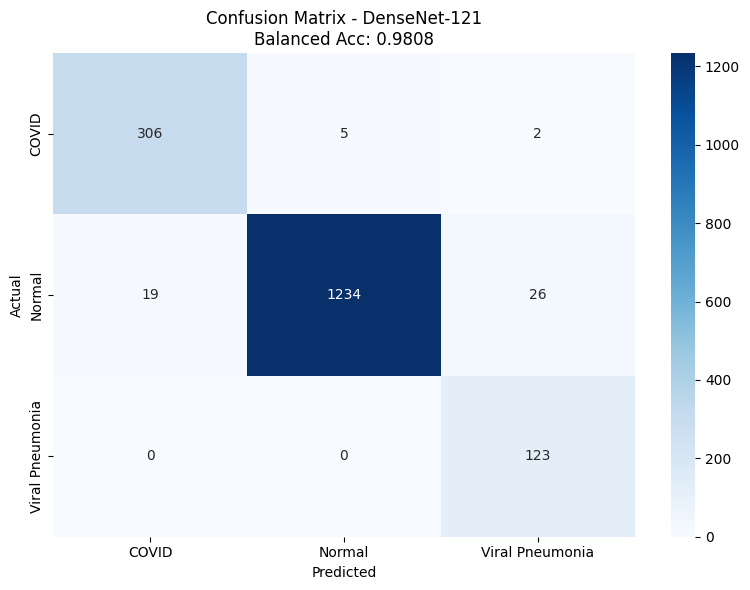


GENERATING SUBMISSION - DENSENET-121
Loaded model: Balanced Acc 0.9808
Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Processing 6382 images...
Progress: 0/6382
Progress: 500/6382
Progress: 1000/6382
Progress: 1500/6382
Progress: 2000/6382
Progress: 2500/6382
Progress: 3000/6382
Progress: 3500/6382
Progress: 4000/6382
Progress: 4500/6382
Progress: 5000/6382
Progress: 5500/6382
Progress: 6000/6382

Submission complete!
Total: 6382

Distribution:
COVID (Class 0): 2013 (31.5%)
Normal (Class 1): 3628 (56.8%)
Viral Pneumonia (Class 2): 741 (11.6%)

Confidence - Mean: 0.9800, Std: 0.0683

Complete!
Best score: 0.9808
Files: best_chest_xray_model_densenet121.pth, submission_densenet121.csv


In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==========================
# Configuration
# ==========================
class Config:
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    batch_size = 32
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 25
    patience = 8
    img_size = 224
    
    print(f"Device: {device}")
    print(f"Image size: {img_size}")

config = Config()

# ==========================
# Data Transforms
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transform_val

# ==========================
# Helper Functions
# ==========================
def analyze_class_distribution(dataset_path):
    class_counts = {}
    total = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count
    
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")
    print(f"Total: {total:,} samples")
    print("="*40)
    
    return class_counts, total

def create_weighted_sampler(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    class_weights = {}
    total_samples = sum(class_counts.values())
    
    for class_idx, count in class_counts.items():
        class_weights[class_idx] = total_samples / (len(class_counts) * count)
    
    sample_weights = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        sample_weights.append(class_weights[label])
    
    print("\nClass weights for sampling:")
    for class_idx, weight in class_weights.items():
        print(f"Class {class_idx}: {weight:.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

# ==========================
# Model (DenseNet-121)
# ==========================
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        # Load DenseNet-121 backbone
        self.backbone = models.densenet121(pretrained=pretrained)
        num_features = self.backbone.classifier.in_features
        
        # Remove original classifier
        self.backbone.classifier = nn.Identity()
        
        # Custom classifier head (sama dengan ResNet untuk konsistensi)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        self._init_classifier()
    
    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==========================
# Training Functions
# ==========================
def calculate_class_weights(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    total = sum(class_counts.values())
    weights = []
    
    for i in range(len(class_counts)):
        weight = total / (len(class_counts) * class_counts[i])
        weights.append(weight)
    
    return torch.FloatTensor(weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    return avg_loss, accuracy, balanced_acc, f1, all_predictions, all_targets

# ==========================
# Main Training
# ==========================
def train_model():
    print("\n" + "="*60)
    print("TRAINING DENSENET-121 FOR CHEST X-RAY CLASSIFICATION")
    print("="*60)
    
    # Load and analyze dataset
    temp_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    analyze_class_distribution(config.train_dir)
    class_names = temp_dataset.classes
    num_classes = len(class_names)
    
    print(f"\nClasses: {class_names}")
    
    # Create datasets
    full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_temp = random_split(full_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # Validation dataset
    val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    
    class ValDataset:
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]
    
    val_dataset = ValDataset(val_full_dataset, val_temp.indices)
    
    print(f"\nTrain: {len(train_dataset):,} | Val: {len(val_dataset):,}")
    
    # Create samplers and loaders
    train_sampler = create_weighted_sampler(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                            sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    print(f"\nInitializing DenseNet-121...")
    model = ChestXrayClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer
    class_weights = calculate_class_weights(train_dataset).to(config.device)
    print(f"\nClass weights: {class_weights}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, 
                           weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                     factor=0.5, patience=4, 
                                                     verbose=True, min_lr=1e-7)
    
    # Training loop
    print(f"\nStarting training for {config.num_epochs} epochs...")
    best_balanced_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print('='*50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                           optimizer, config.device)
        val_loss, val_acc, val_balanced_acc, val_f1, _, _ = validate_epoch(
            model, val_loader, criterion, config.device)
        
        scheduler.step(val_balanced_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nResults:")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Balanced: {val_balanced_acc:.4f}, F1: {val_f1:.4f}")
        print(f"LR: {current_lr:.2e}")
        
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }, 'best_chest_xray_model_densenet121.pth')
            print(f"New best: Balanced Acc {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE - Best: {best_balanced_acc:.4f}")
    print('='*60)
    
    # Final validation
    checkpoint = torch.load('best_chest_xray_model_densenet121.pth', 
                          map_location=config.device, 
                          weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    _, final_acc, final_balanced, final_f1, final_preds, final_targets = validate_epoch(
        model, val_loader, criterion, config.device)
    
    print("\n" + "="*40)
    print("FINAL VALIDATION REPORT")
    print("="*40)
    print(f"Accuracy: {final_acc:.4f}")
    print(f"Balanced Accuracy: {final_balanced:.4f}")
    print(f"F1 Score (Macro): {final_f1:.4f}")
    print("\nDetailed Report:")
    print(classification_report(final_targets, final_preds, 
                               target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(final_targets, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - DenseNet-121\nBalanced Acc: {final_balanced:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix_densenet121.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, class_names, best_balanced_acc

# ==========================
# Prediction Functions
# ==========================
def predict_with_tta(model, image_path):
    model.eval()
    
    tta_transforms = [
        transform_test,
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ]
    
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0).to(config.device)
                
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predictions.append(probabilities.cpu().numpy())
            except Exception:
                continue
    
    if predictions:
        return np.mean(predictions, axis=0)
    else:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform_test(image).unsqueeze(0).to(config.device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

# ==========================
# Generate Submission
# ==========================
def generate_submission():
    print("\n" + "="*60)
    print("GENERATING SUBMISSION - DENSENET-121")
    print("="*60)
    
    checkpoint = torch.load('best_chest_xray_model_densenet121.pth', 
                          map_location=config.device,
                          weights_only=False)
    class_names = checkpoint['class_names']
    
    model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    
    print(f"Loaded model: Balanced Acc {checkpoint['best_balanced_acc']:.4f}")
    print(f"Classes: {class_names}")
    
    test_images = sorted([f for f in os.listdir(config.test_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} images...")
    
    image_ids = []
    predictions = []
    confidences = []
    
    for i, img_name in enumerate(test_images):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(test_images)}")
        
        img_path = os.path.join(config.test_dir, img_name)
        
        try:
            prob_vector = predict_with_tta(model, img_path)
            pred_class = np.argmax(prob_vector)
            confidence = np.max(prob_vector)
            
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(pred_class)
            confidences.append(confidence)
            
        except Exception as e:
            print(f"Error {img_name}: {e}")
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(1)
            confidences.append(0.33)
    
    # Create submission
    submission_df = pd.DataFrame({
        'Id': image_ids,
        'Predicted': predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv('submission_densenet121.csv', index=False)
    
    print(f"\nSubmission complete!")
    print(f"Total: {len(submission_df)}")
    
    print("\nDistribution:")
    for idx in range(len(class_names)):
        count = (submission_df['Predicted'] == idx).sum()
        pct = count / len(submission_df) * 100
        print(f"{class_names[idx]} (Class {idx}): {count} ({pct:.1f}%)")
    
    print(f"\nConfidence - Mean: {np.mean(confidences):.4f}, "
          f"Std: {np.std(confidences):.4f}")
    
    return submission_df

# ==========================
# Main Execution
# ==========================
if __name__ == "__main__":
    print("DenseNet-121 Chest X-Ray Classifier")
    print("="*60)
    
    try:
        model, class_names, best_score = train_model()
        submission = generate_submission()
        
        print("\nComplete!")
        print(f"Best score: {best_score:.4f}")
        print("Files: best_chest_xray_model_densenet121.pth, submission_densenet121.csv")
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()

**EFFNET V2S**

Device: cuda
Image size: 384
EfficientNetV2-S Chest X-Ray Classifier

TRAINING EFFICIENTNETV2-S FOR CHEST X-RAY CLASSIFICATION

CLASS DISTRIBUTION ANALYSIS
COVID: 1,596 samples (18.6%)
Normal: 6,310 samples (73.6%)
Viral Pneumonia: 666 samples (7.8%)
Total: 8,572 samples

Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Train: 6,857 | Val: 1,715

Class weights for sampling:
Class 1: 0.454
Class 2: 4.209
Class 0: 1.782

Initializing EfficientNetV2-S...


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s]


Total parameters: 20,966,995
Trainable parameters: 20,966,995

Class weights: tensor([1.7815, 0.4543, 4.2093], device='cuda:0')

Starting training for 25 epochs...

Epoch 1/25
Batch 0/215, Loss: 1.3806
Batch 50/215, Loss: 0.1962
Batch 100/215, Loss: 0.1291
Batch 150/215, Loss: 0.0777
Batch 200/215, Loss: 0.1969

Results:
Train - Loss: 0.2738, Acc: 0.8117
Val   - Loss: 0.1458, Acc: 0.9277, Balanced: 0.9564, F1: 0.9016
LR: 9.05e-05
New best: Balanced Acc 0.9564

Epoch 2/25
Batch 0/215, Loss: 0.1052
Batch 50/215, Loss: 0.0728
Batch 100/215, Loss: 0.0335
Batch 150/215, Loss: 0.0807
Batch 200/215, Loss: 0.0259

Results:
Train - Loss: 0.0715, Acc: 0.9580
Val   - Loss: 0.1131, Acc: 0.9808, Balanced: 0.9655, F1: 0.9685
LR: 6.55e-05
New best: Balanced Acc 0.9655

Epoch 3/25
Batch 0/215, Loss: 0.0311
Batch 50/215, Loss: 0.0144
Batch 100/215, Loss: 0.0350
Batch 150/215, Loss: 0.0027
Batch 200/215, Loss: 0.0063

Results:
Train - Loss: 0.0377, Acc: 0.9767
Val   - Loss: 0.1340, Acc: 0.9580, Balanced

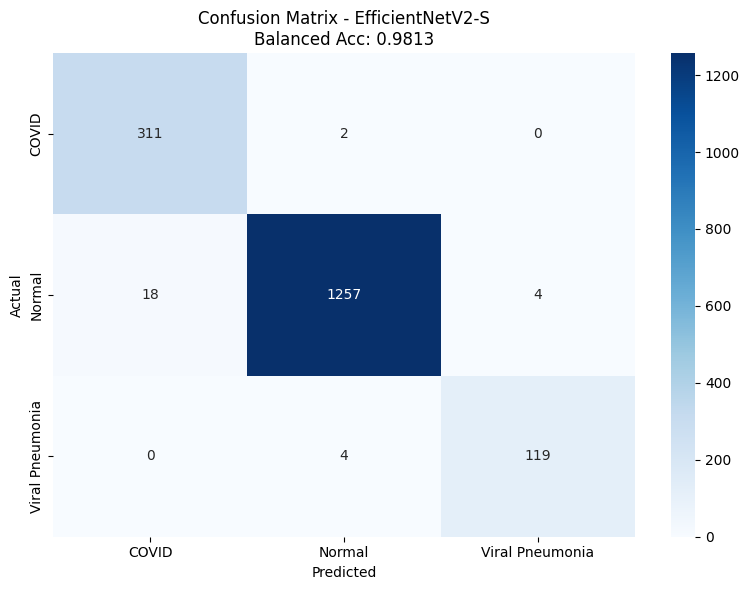


GENERATING SUBMISSION - EFFICIENTNETV2-S
Loaded model: Balanced Acc 0.9813
Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Processing 6382 images...
Progress: 0/6382
Progress: 500/6382
Progress: 1000/6382
Progress: 1500/6382
Progress: 2000/6382
Progress: 2500/6382
Progress: 3000/6382
Progress: 3500/6382
Progress: 4000/6382
Progress: 4500/6382
Progress: 5000/6382
Progress: 5500/6382
Progress: 6000/6382

Submission complete!
Total: 6382

Distribution:
COVID (Class 0): 2031 (31.8%)
Normal (Class 1): 3681 (57.7%)
Viral Pneumonia (Class 2): 670 (10.5%)

Confidence - Mean: 0.9970, Std: 0.0283

Complete!
Best score: 0.9813
Files: best_chest_xray_model_effnetv2s.pth, submission_effnetv2s.csv


In [19]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==========================
# Configuration
# ==========================
class Config:
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    batch_size = 32
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 25
    patience = 8
    img_size = 384  # EfficientNetV2-S works best with 384
    
    print(f"Device: {device}")
    print(f"Image size: {img_size}")

config = Config()

# ==========================
# Data Transforms
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transform_val

# ==========================
# Helper Functions
# ==========================
def analyze_class_distribution(dataset_path):
    class_counts = {}
    total = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count
    
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")
    print(f"Total: {total:,} samples")
    print("="*40)
    
    return class_counts, total

def create_weighted_sampler(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    class_weights = {}
    total_samples = sum(class_counts.values())
    
    for class_idx, count in class_counts.items():
        class_weights[class_idx] = total_samples / (len(class_counts) * count)
    
    sample_weights = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        sample_weights.append(class_weights[label])
    
    print("\nClass weights for sampling:")
    for class_idx, weight in class_weights.items():
        print(f"Class {class_idx}: {weight:.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

# ==========================
# Model (EfficientNetV2-S)
# ==========================
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        # Load EfficientNetV2-S backbone
        self.backbone = models.efficientnet_v2_s(weights='DEFAULT' if pretrained else None)
        num_features = self.backbone.classifier[1].in_features
        
        # Remove original classifier
        self.backbone.classifier = nn.Identity()
        
        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        self._init_classifier()
    
    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==========================
# Training Functions
# ==========================
def calculate_class_weights(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    total = sum(class_counts.values())
    weights = []
    
    for i in range(len(class_counts)):
        weight = total / (len(class_counts) * class_counts[i])
        weights.append(weight)
    
    return torch.FloatTensor(weights)

def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    balanced_acc = balanced_accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='macro')
    
    return avg_loss, accuracy, balanced_acc, f1, all_predictions, all_targets

# ==========================
# Main Training
# ==========================
def train_model():
    print("\n" + "="*60)
    print("TRAINING EFFICIENTNETV2-S FOR CHEST X-RAY CLASSIFICATION")
    print("="*60)
    
    # Load and analyze dataset
    temp_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    analyze_class_distribution(config.train_dir)
    class_names = temp_dataset.classes
    num_classes = len(class_names)
    
    print(f"\nClasses: {class_names}")
    
    # Create datasets
    full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_temp = random_split(full_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # Validation dataset
    val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    
    class ValDataset:
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]
    
    val_dataset = ValDataset(val_full_dataset, val_temp.indices)
    
    print(f"\nTrain: {len(train_dataset):,} | Val: {len(val_dataset):,}")
    
    # Create samplers and loaders
    train_sampler = create_weighted_sampler(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                            sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    print(f"\nInitializing EfficientNetV2-S...")
    model = ChestXrayClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer
    class_weights = calculate_class_weights(train_dataset).to(config.device)
    print(f"\nClass weights: {class_weights}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, 
                           weight_decay=config.weight_decay)
    
    # Cosine Annealing scheduler (better for EfficientNetV2)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    
    # Mixed precision scaler
    scaler = torch.cuda.amp.GradScaler() if config.device.type == 'cuda' else None
    
    # Training loop
    print(f"\nStarting training for {config.num_epochs} epochs...")
    best_balanced_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print('='*50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                           optimizer, config.device, scaler)
        val_loss, val_acc, val_balanced_acc, val_f1, _, _ = validate_epoch(
            model, val_loader, criterion, config.device)
        
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nResults:")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Balanced: {val_balanced_acc:.4f}, F1: {val_f1:.4f}")
        print(f"LR: {current_lr:.2e}")
        
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }, 'best_chest_xray_model_effnetv2s.pth')
            print(f"New best: Balanced Acc {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE - Best: {best_balanced_acc:.4f}")
    print('='*60)
    
    # Final validation
    checkpoint = torch.load('best_chest_xray_model_effnetv2s.pth', 
                          map_location=config.device, 
                          weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    _, final_acc, final_balanced, final_f1, final_preds, final_targets = validate_epoch(
        model, val_loader, criterion, config.device)
    
    print("\n" + "="*40)
    print("FINAL VALIDATION REPORT")
    print("="*40)
    print(f"Accuracy: {final_acc:.4f}")
    print(f"Balanced Accuracy: {final_balanced:.4f}")
    print(f"F1 Score (Macro): {final_f1:.4f}")
    print("\nDetailed Report:")
    print(classification_report(final_targets, final_preds, 
                               target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(final_targets, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - EfficientNetV2-S\nBalanced Acc: {final_balanced:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix_effnetv2s.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, class_names, best_balanced_acc

# ==========================
# Generate Submission
# ==========================
def generate_submission():
    print("\n" + "="*60)
    print("GENERATING SUBMISSION - EFFICIENTNETV2-S")
    print("="*60)
    
    checkpoint = torch.load('best_chest_xray_model_effnetv2s.pth', 
                          map_location=config.device,
                          weights_only=False)
    class_names = checkpoint['class_names']
    
    model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    
    print(f"Loaded model: Balanced Acc {checkpoint['best_balanced_acc']:.4f}")
    print(f"Classes: {class_names}")
    
    test_images = sorted([f for f in os.listdir(config.test_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} images...")
    
    image_ids = []
    predictions = []
    confidences = []
    
    for i, img_name in enumerate(test_images):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(test_images)}")
        
        img_path = os.path.join(config.test_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
            image_tensor = transform_test(image).unsqueeze(0).to(config.device)
            
            with torch.no_grad():
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
            
            pred_class = torch.argmax(probabilities, dim=1).item()
            confidence = torch.max(probabilities).item()
            
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(pred_class)
            confidences.append(confidence)
            
        except Exception as e:
            print(f"Error {img_name}: {e}")
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(1)
            confidences.append(0.33)
    
    # Create submission
    submission_df = pd.DataFrame({
        'Id': image_ids,
        'Predicted': predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv('submission_effnetv2s.csv', index=False)
    
    print(f"\nSubmission complete!")
    print(f"Total: {len(submission_df)}")
    
    print("\nDistribution:")
    for idx in range(len(class_names)):
        count = (submission_df['Predicted'] == idx).sum()
        pct = count / len(submission_df) * 100
        print(f"{class_names[idx]} (Class {idx}): {count} ({pct:.1f}%)")
    
    print(f"\nConfidence - Mean: {np.mean(confidences):.4f}, "
          f"Std: {np.std(confidences):.4f}")
    
    return submission_df

# ==========================
# Main Execution
# ==========================
if __name__ == "__main__":
    print("EfficientNetV2-S Chest X-Ray Classifier")
    print("="*60)
    
    try:
        model, class_names, best_score = train_model()
        submission = generate_submission()
        
        print("\nComplete!")
        print(f"Best score: {best_score:.4f}")
        print("Files: best_chest_xray_model_effnetv2s.pth, submission_effnetv2s.csv")
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()

**REGNET**

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, f1_score
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# ==========================
# Configuration
# ==========================
class Config:
    train_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
    test_dir = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    batch_size = 32
    learning_rate = 1e-4
    weight_decay = 1e-4
    num_epochs = 25
    patience = 8
    img_size = 224
    
    print(f"Device: {device}")
    print(f"Image size: {img_size}")

config = Config()

# ==========================
# Data Transforms
# ==========================
transform_train = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transform_val

# ==========================
# Helper Functions
# ==========================
def analyze_class_distribution(dataset_path):
    class_counts = {}
    total = 0
    
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
            total += count
    
    print("\n" + "="*40)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*40)
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100 if total > 0 else 0
        print(f"{class_name}: {count:,} samples ({percentage:.1f}%)")
    print(f"Total: {total:,} samples")
    print("="*40)
    
    return class_counts, total

def create_weighted_sampler(dataset):
    """
    dataset can be an ImageFolder or a Subset of ImageFolder.
    This function computes per-sample weights based on class frequency.
    """
    # get label for each sample
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(label)
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)
    
    # avoid division by zero
    class_weights = {cls: total_samples / (num_classes * count) if count > 0 else 0.0
                     for cls, count in class_counts.items()}
    
    sample_weights = [class_weights[label] for label in labels]
    
    print("\nClass weights for sampling:")
    for class_idx, weight in class_weights.items():
        print(f"Class {class_idx}: {weight:.3f}")
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

# ==========================
# Model (RegNet - regnet_y_1_6gf)
# ==========================
class ChestXrayClassifier(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(ChestXrayClassifier, self).__init__()
        
        # Load RegNet backbone (y_1_6gf is a good-performance variant)
        # If your torchvision version doesn't accept pretrained=True, replace with weights=...
        self.backbone = models.regnet_y_1_6gf(pretrained=pretrained)
        
        # RegNet's final layer is `fc`
        num_features = self.backbone.fc.in_features
        
        # Remove original classifier head
        self.backbone.fc = nn.Identity()
        
        # Custom classifier head (kept similar to previous DenseNet head)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        self._init_classifier()
    
    def _init_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==========================
# Training Functions
# ==========================
def calculate_class_weights(dataset):
    """
    Calculate class weights for CrossEntropyLoss based on dataset labels.
    Works with Subset or ImageFolder.
    """
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(label)
    class_counts = Counter(labels)
    total = sum(class_counts.values())
    num_classes = len(class_counts)
    
    weights = []
    for cls_idx in range(num_classes):
        count = class_counts.get(cls_idx, 0)
        weight = total / (num_classes * count) if count > 0 else 0.0
        weights.append(weight)
    
    return torch.FloatTensor(weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0
    balanced_acc = balanced_accuracy_score(all_targets, all_predictions) if len(all_targets) > 0 else 0.0
    f1 = f1_score(all_targets, all_predictions, average='macro') if len(all_targets) > 0 else 0.0
    
    return avg_loss, accuracy, balanced_acc, f1, all_predictions, all_targets

# ==========================
# Main Training
# ==========================
def train_model():
    print("\n" + "="*60)
    print("TRAINING REGNET-Y-1_6GF FOR CHEST X-RAY CLASSIFICATION")
    print("="*60)
    
    # Load and analyze dataset
    temp_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    analyze_class_distribution(config.train_dir)
    class_names = temp_dataset.classes
    num_classes = len(class_names)
    
    print(f"\nClasses: {class_names}")
    
    # Create datasets
    full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_train)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_temp = random_split(full_dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
    
    # Validation dataset (wrap underlying ImageFolder with val indices)
    val_full_dataset = datasets.ImageFolder(root=config.train_dir, transform=transform_val)
    
    class ValDataset:
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            return self.base_dataset[self.indices[idx]]
    
    val_dataset = ValDataset(val_full_dataset, val_temp.indices)
    
    print(f"\nTrain: {len(train_dataset):,} | Val: {len(val_dataset):,}")
    
    # Create samplers and loaders
    train_sampler = create_weighted_sampler(train_dataset)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size,
                            sampler=train_sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                          shuffle=False, num_workers=2, pin_memory=True)
    
    # Initialize model
    print(f"\nInitializing RegNet (regnet_y_1_6gf)...")
    model = ChestXrayClassifier(num_classes=num_classes, pretrained=True)
    model = model.to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Loss and optimizer
    class_weights = calculate_class_weights(train_dataset).to(config.device)
    print(f"\nClass weights: {class_weights}")
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, 
                           weight_decay=config.weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                     factor=0.5, patience=4, 
                                                     verbose=True, min_lr=1e-7)
    
    # Training loop
    print(f"\nStarting training for {config.num_epochs} epochs...")
    best_balanced_acc = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print('='*50)
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                           optimizer, config.device)
        val_loss, val_acc, val_balanced_acc, val_f1, _, _ = validate_epoch(
            model, val_loader, criterion, config.device)
        
        scheduler.step(val_balanced_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"\nResults:")
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, "
              f"Balanced: {val_balanced_acc:.4f}, F1: {val_f1:.4f}")
        print(f"LR: {current_lr:.2e}")
        
        if val_balanced_acc > best_balanced_acc:
            best_balanced_acc = val_balanced_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_balanced_acc': best_balanced_acc,
                'class_names': class_names
            }, 'best_chest_xray_model_regnet_y_1_6gf.pth')
            print(f"New best: Balanced Acc {best_balanced_acc:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE - Best: {best_balanced_acc:.4f}")
    print('='*60)
    
    # Final validation - load best checkpoint
    checkpoint = torch.load('best_chest_xray_model_regnet_y_1_6gf.pth', 
                          map_location=config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    _, final_acc, final_balanced, final_f1, final_preds, final_targets = validate_epoch(
        model, val_loader, criterion, config.device)
    
    print("\n" + "="*40)
    print("FINAL VALIDATION REPORT")
    print("="*40)
    print(f"Accuracy: {final_acc:.4f}")
    print(f"Balanced Accuracy: {final_balanced:.4f}")
    print(f"F1 Score (Macro): {final_f1:.4f}")
    print("\nDetailed Report:")
    print(classification_report(final_targets, final_preds, 
                               target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(final_targets, final_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - RegNet-Y-1_6GF\nBalanced Acc: {final_balanced:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix_regnet_y_1_6gf.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return model, class_names, best_balanced_acc

# ==========================
# Prediction Functions
# ==========================
def predict_with_tta(model, image_path):
    model.eval()
    
    tta_transforms = [
        transform_test,
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize((config.img_size, config.img_size)),
            transforms.RandomRotation(degrees=5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    ]
    
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0).to(config.device)
                
                outputs = model(image_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                predictions.append(probabilities.cpu().numpy())
            except Exception:
                continue
    
    if predictions:
        return np.mean(predictions, axis=0)
    else:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform_test(image).unsqueeze(0).to(config.device)
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        return probabilities.cpu().numpy()

# ==========================
# Generate Submission
# ==========================
def generate_submission():
    print("\n" + "="*60)
    print("GENERATING SUBMISSION - REGNET-Y-1_6GF")
    print("="*60)
    
    checkpoint = torch.load('best_chest_xray_model_regnet_y_1_6gf.pth', 
                          map_location=config.device)
    class_names = checkpoint['class_names']
    
    model = ChestXrayClassifier(num_classes=len(class_names), pretrained=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(config.device)
    model.eval()
    
    print(f"Loaded model: Balanced Acc {checkpoint['best_balanced_acc']:.4f}")
    print(f"Classes: {class_names}")
    
    test_images = sorted([f for f in os.listdir(config.test_dir) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"\nProcessing {len(test_images)} images...")
    
    image_ids = []
    predictions = []
    confidences = []
    
    for i, img_name in enumerate(test_images):
        if i % 500 == 0:
            print(f"Progress: {i}/{len(test_images)}")
        
        img_path = os.path.join(config.test_dir, img_name)
        
        try:
            prob_vector = predict_with_tta(model, img_path)
            pred_class = np.argmax(prob_vector)
            confidence = np.max(prob_vector)
            
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(pred_class)
            confidences.append(confidence)
            
        except Exception as e:
            print(f"Error {img_name}: {e}")
            image_ids.append(os.path.splitext(img_name)[0])
            predictions.append(1)
            confidences.append(0.33)
    
    # Create submission
    submission_df = pd.DataFrame({
        'Id': image_ids,
        'Predicted': predictions
    })
    
    submission_df = submission_df.sort_values('Id').reset_index(drop=True)
    submission_df.to_csv('submission_regnet_y_1_6gf.csv', index=False)
    
    print(f"\nSubmission complete!")
    print(f"Total: {len(submission_df)}")
    
    print("\nDistribution:")
    for idx in range(len(class_names)):
        count = (submission_df['Predicted'] == idx).sum()
        pct = count / len(submission_df) * 100 if len(submission_df) > 0 else 0.0
        print(f"{class_names[idx]} (Class {idx}): {count} ({pct:.1f}%)")
    
    print(f"\nConfidence - Mean: {np.mean(confidences):.4f}, "
          f"Std: {np.std(confidences):.4f}")
    
    return submission_df

# ==========================
# Main Execution
# ==========================
if __name__ == "__main__":
    print("RegNet-Y-1_6GF Chest X-Ray Classifier")
    print("="*60)
    
    try:
        model, class_names, best_score = train_model()
        submission = generate_submission()
        
        print("\nComplete!")
        print(f"Best score: {best_score:.4f}")
        print("Files: best_chest_xray_model_regnet_y_1_6gf.pth, submission_regnet_y_1_6gf.csv")
        
    except Exception as e:
        print(f"\nError: {e}")
        import traceback
        traceback.print_exc()


Device: cuda
Image size: 224
RegNet-Y-1_6GF Chest X-Ray Classifier

TRAINING REGNET-Y-1_6GF FOR CHEST X-RAY CLASSIFICATION

CLASS DISTRIBUTION ANALYSIS
COVID: 1,596 samples (18.6%)
Normal: 6,310 samples (73.6%)
Viral Pneumonia: 666 samples (7.8%)
Total: 8,572 samples

Classes: ['COVID', 'Normal', 'Viral Pneumonia']

Train: 6,857 | Val: 1,715

Class weights for sampling:
Class 1: 0.454
Class 2: 4.209
Class 0: 1.782

Initializing RegNet (regnet_y_1_6gf)...


Downloading: "https://download.pytorch.org/models/regnet_y_1_6gf-b11a554e.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_1_6gf-b11a554e.pth
100%|██████████| 43.2M/43.2M [00:00<00:00, 179MB/s] 


Total parameters: 10,902,233
Trainable parameters: 10,902,233

Class weights: tensor([1.7815, 0.4543, 4.2093], device='cuda:0')

Starting training for 25 epochs...

Epoch 1/25
Batch 0/215, Loss: 1.0354
Batch 50/215, Loss: 0.2368
Batch 100/215, Loss: 0.1512
Batch 150/215, Loss: 0.1683
Batch 200/215, Loss: 0.0353

Results:
Train - Loss: 0.2465, Acc: 0.7890
Val   - Loss: 0.1842, Acc: 0.9668, Balanced: 0.9333, F1: 0.9485
LR: 1.00e-04
New best: Balanced Acc 0.9333

Epoch 2/25
Batch 0/215, Loss: 0.0926
Batch 50/215, Loss: 0.0212
Batch 100/215, Loss: 0.1451
Batch 150/215, Loss: 0.0838
Batch 200/215, Loss: 0.0099

Results:
Train - Loss: 0.0680, Acc: 0.9533
Val   - Loss: 0.1013, Acc: 0.9697, Balanced: 0.9654, F1: 0.9551
LR: 1.00e-04
New best: Balanced Acc 0.9654

Epoch 3/25
Batch 0/215, Loss: 0.0126
Batch 50/215, Loss: 0.0270
Batch 100/215, Loss: 0.0376
Batch 150/215, Loss: 0.0030
Batch 200/215, Loss: 0.0188

Results:
Train - Loss: 0.0480, Acc: 0.9711
Val   - Loss: 0.1526, Acc: 0.9697, Balanced

Traceback (most recent call last):
  File "/tmp/ipykernel_36/2110193144.py", line 517, in <cell line: 0>
    model, class_names, best_score = train_model()
                                     ^^^^^^^^^^^^^
  File "/tmp/ipykernel_36/2110193144.py", line 360, in train_model
    checkpoint = torch.load('best_chest_xray_model_regnet_y_1_6gf.pth',
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 1470, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution

**ENESEMBLE 4 MODEL**

In [1]:
# ============================================================
# ENSEMBLE EfficientNet-B0 + B2 dengan TTA untuk Submission
# ============================================================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# CONFIG
# ============================================================
class Config:
    NUM_CLASSES = 3
    IMG_SIZE_B0 = 224
    IMG_SIZE_B2 = 260
    
    # Path model hasil training kamu
    MODEL_B0_PATH = "/kaggle/input/finetuning-b0/pytorch/default/1/best_final_finetuneB0.pth"
    MODEL_B2_PATH = "/kaggle/input/finetuning-b2/pytorch/default/1/best_final_finetune_b2 (1)9927.pth"
    
    TEST_DIR = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
    SUBMISSION_PATH = "/kaggle/working/submission.csv"

config = Config()

# ============================================================
# MODEL DEFINITIONS SAMA PERSIS DENGAN TRAINING
# ============================================================
class EfficientXRayClassifierB0(nn.Module):
    def _init_(self, num_classes=3, dropout=0.3):
        super()._init_()
        self.backbone = models.efficientnet_b0(weights=None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout*0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

class EfficientXRayClassifierB2(nn.Module):
    def _init_(self, num_classes=3, dropout=0.4):
        super()._init_()
        self.backbone = models.efficientnet_b2(weights=None)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout*0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

# ============================================================
# LOAD CHECKPOINT
# ============================================================
def load_model(model_class, checkpoint_path, num_classes, dropout):
    model = model_class(num_classes=num_classes, dropout=dropout)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=False)
    model = model.to(device)
    model.eval()
    return model

# ============================================================
# TTA TRANSFORMS
# ============================================================
def get_tta_transforms(img_size):
    return [
        transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ]),
        transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ]),
        transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(degrees=10, fill=0),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],
                                 std=[0.229,0.224,0.225])
        ]),
    ]

# ============================================================
# PREDICT ENSEMBLE + TTA UNTUK 1 GAMBAR
# ============================================================
def predict_image(image, models_and_ttas):
    all_logits = []
    with torch.no_grad():
        for model, tta_transforms in models_and_ttas:
            logits_tta = []
            for tta in tta_transforms:
                img_tensor = tta(image).unsqueeze(0).to(device)
                output = model(img_tensor)
                logits_tta.append(output)
            avg_logits = torch.mean(torch.stack(logits_tta), dim=0)
            all_logits.append(avg_logits)
    final_logits = torch.mean(torch.stack(all_logits), dim=0)
    probs = F.softmax(final_logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    return pred_class

# ============================================================
# MAIN INFERENCE
# ============================================================
if _name_ == "_main_":
    # Load models sesuai training
    model_b0 = load_model(EfficientXRayClassifierB0, config.MODEL_B0_PATH, config.NUM_CLASSES, dropout=0.3)
    model_b2 = load_model(EfficientXRayClassifierB2, config.MODEL_B2_PATH, config.NUM_CLASSES, dropout=0.4)

    # TTA untuk tiap model
    tta_b0 = get_tta_transforms(config.IMG_SIZE_B0)
    tta_b2 = get_tta_transforms(config.IMG_SIZE_B2)
    models_and_ttas = [(model_b0, tta_b0), (model_b2, tta_b2)]

    # Loop test set
    test_images = sorted(os.listdir(config.TEST_DIR))
    results = []
    for img_name in tqdm(test_images, desc="Predicting"):
        img_path = os.path.join(config.TEST_DIR, img_name)
        image = Image.open(img_path).convert("RGB")
        pred = predict_image(image, models_and_ttas)
        img_id = os.path.splitext(img_name)[0]  # misal test_0000
        results.append({"Id": img_id, "Predicted": pred})

    # Save CSV submission
    df = pd.DataFrame(results)
    df.to_csv(config.SUBMISSION_PATH, index=False)
    print(f"✅ Submission saved to {config.SUBMISSION_PATH}")